# Домашнее задание
## Предварительный анализ задачи торговой стратегии

Цель:
В данном домашнем задании вы потренируетесь в процессе сбора данных, их предобработки и отображения.


Описание/Пошаговая инструкция выполнения домашнего задания:
Уважаемый студент!


Вас пригласили на работу в коммерческую компанию, занимающуюся
разработкой автоматизированных торговых агентов.
Одной из первых ваших задач будет подготовка данных для дальнейшей
обработки и построения модели.
Пообщавшись с коллегами, вы узнали, что вам предстоит работать с
несколькими типами активов: акциями из списка SnP500 и криптовалютами (BTC, ETH,
SOL, XRP). Вам планируют поручить краткосрочную и среднесрочную торговлю.


Вам предлагается на основе предоставленной информации:


Создать git-репозиторий, где будет храниться исходный код вашего проекта.
Если вы используете приватный репозиторий – дайте преподавателям курса доступ к
нему, для возможности проверки ДЗ.
Добавить файл лицензии, который отражает ваш взгляд на конфиденциальность
информации, которую вы подготовите в рамках данного курса.
Создать код на Python, который загрузит на ваш локальный компьютер данные о
котировках ценных бумаг из списка SnP500 и котировки криптовалют (BTC, ETH, SOL,
XRP).
Поскольку вам предстоит много работать с ними в дальнейшем, подготовьте
автоматическое отображение графиков текущей ситуации.
Проверьте нет ли в данных пропусков или ошибок. Проанализируйте выбросы.
Оцените, на самом ли деле это выбросы или реальные данные, с которыми предстоит
работать.
Желаем успехов!

Критерии оценки:
Для того, чтобы вашу работу зачли необходимо выполнить 1; 3; 4; 5 пункты задания.


Компетенции:
Основы финансовых рынков и машинного обучения
- Знать основные библиотеки и инструменты для анализа данных на Python.
- Применять Python для анализа и визуализации финансовых данных.
- Решать практические задачи по обработке и анализу финансовых данных с использованием Python.

# выполнение ДЗ
## По согласованию с руководителем курса возьму акции MOEX

### Модель данных
БД
#### Таблица symbol - список акций
 - symbol_id
 - symbol
 - otrasol_index (из Таблица отраслей)
 - link
 - name_link
#### Таблица aktiv - список активов
 - symbol_id (из Таблица symbol)
 - name_aktive - название_актива
 - otmetka_div - отметка о дивидендах
 - otmetka_my - отметка "мой портфель"
 - otmetka_track - отметка "отслеживать"
#### Таблица otrasol
 - otrasol_index
 - otrasol
#### Таблица kotirivki_interval (date_interval)
Вариация по скачиваемым данным
interval=1 - 1 минута
interval=10 - 10 минут
interval=60 - 1 час
interval=24 - 1 день
interval=7 - 1 неделя
interval=31 - 1 месяц
interval=4 - 1 квартал
#### Таблица календарь - календарь
 - дата-время дд-мм-гггг чч:мм:сс
 - год
 - месяц
 - день
 - час
 - минута
 - неделя
 - квартал
 - полугодие
 - номера часа в месяце
 - номер часа в году
#### Функции
 - функции проверки данных: проверка пустых. проверка выбросов
 - функция записи новых котировок в БД
 - функция считывания котировок
 - функция считавание ексель-файлов

In [63]:
#импорты
import pandas as pd
import sys
import sqlalchemy
import sqlite3
import datetime as dt
import requests

In [64]:
#вспомогтальные функции
#функция считавание ексель-файлов
#sys.path.append(r'C:\Users\smndy\Documents\PycharmProjects\Py_scripts\parse_xlsx')
from get_xlsx import get_xlsx

#функция считывания котировок
#sys.path.append(r'C:\Users\smndy\Documents\PycharmProjects\Py_scripts\get_kotirovki')
from get_kotirovki import get_kotirovki

In [65]:
def write_to_database(df, db_name=None, table_name=None, if_exists='fail'):
    """
    Записывает данные из DataFrame в таблицу SQLite базы данных.

    Args:
        df (pd.DataFrame): Данные, которые необходимо записать в базу данных.
        db_name (str): Имя файла базы данных SQLite (по умолчанию 'database.db').
        table_name (str): Имя таблицы для записи данных.
        if_exists (str): Как поступить, если таблица существует. Допустимые значения:
                         'fail' (по умолчанию), 'replace', 'append'.
    
    Raises:
        ValueError: Если имя таблицы не указано или параметр if_exists имеет неверное значение.
    """
    # Проверка, указано ли имя БД 
    if db_name is None:
        raise ValueError("Необходимо указать имя БД для записи данных.")    
    # Проверка, указано ли имя таблицы
    if table_name is None:
        raise ValueError("Необходимо указать имя таблицы для записи данных.")
    
    # Проверка допустимых значений параметра if_exists
    if if_exists not in ['fail', 'replace', 'append']:
        raise ValueError("Параметр if_exists может принимать только значения 'fail', 'replace' или 'append'.")
    
    # Создание подключения к базе данных
    conn = sqlite3.connect(db_name)
    
    try:
        # Запись данных в таблицу
        df.to_sql(table_name, conn, if_exists=if_exists, index=False)
        print(f"Данные успешно записаны в таблицу '{table_name}' базы данных '{db_name}'")
    except Exception as e:
        print(f"Ошибка при записи данных в базу: {e}")
    finally:
        # Закрытие соединения с базой данных
        conn.close()


In [66]:
#функция чтения в 'database.db'
def read_from_database(db_name='database.db', table_name=None, query=None):
    """
    Читает данные из таблицы SQLite базы данных и выводит первые 5 строк.

    Args:
        db_name (str): Имя файла базы данных SQLite (по умолчанию 'database.db').
        table_name (str): Имя таблицы для чтения данных.
        query (str): Пользовательский SQL-запрос (если указан).
    
    Returns:
        pd.DataFrame: DataFrame с данными из таблицы.
    """
    # Подключение к базе данных
    conn = sqlite3.connect(db_name)

    try:
        # Если передан запрос, использовать его
        if query:
            df = pd.read_sql_query(query, conn)
        # Если передано имя таблицы, строим стандартный запрос
        elif table_name:
            df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        else:
            raise ValueError("Необходимо передать либо имя таблицы, либо SQL-запрос")

        print(f"Данные успешно прочитаны из таблицы '{table_name}'")
        return df
    except Exception as e:
        print(f"Ошибка при чтении данных: {e}")
    finally:
        # Закрытие соединения с базой данных
        conn.close()

In [124]:
def find_outliers_iqr(df):
    """
    Находит выбросы по межквартильному размаху (IQR) для колонок 'open', 'close', 'high', 'low', 'value'
    и возвращает DataFrame, содержащий выбросы.
    
    Args:
        df (pd.DataFrame): DataFrame с котировками (df_kotirivki).
    
    Returns:
        pd.DataFrame: DataFrame с выбросами по колонкам 'open', 'close', 'high', 'low', 'value'.
    """
    columns = ['open', 'close', 'high', 'low', 'value']
    outlier_rows = pd.DataFrame()
    
    # Проходим по каждой из указанных колонок
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Границы выбросов
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Находим строки с выбросами
            outliers_in_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            
            # Добавляем строки с выбросами в общий DataFrame
            outlier_rows = pd.concat([outlier_rows, outliers_in_col])
    
    # Убираем возможные дубликаты строк
    outlier_rows = outlier_rows.drop_duplicates()
    
    return outlier_rows[columns]

# Пример использования функции:
# outliers_df = find_outliers_iqr(df_kotirivki)
# print(outliers_df)


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_data(df, columns=None):
    """
    Проводит анализ данных:
    - Проверяет наличие пропусков.
    - Строит графики текущей ситуации для выбранных колонок.
    - Анализирует выбросы на основе межквартильного размаха (IQR).
    - Оценивает выбросы.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        columns (list): Список колонок для анализа (по умолчанию все числовые колонки).
    
    Returns:
        pd.DataFrame: DataFrame с выбросами, если они найдены.
    """
    # Если список колонок не задан, берем все числовые
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # 1. Проверка наличия пропусков
    print("Проверка пропусков:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    # 2. Построение графиков
    print("\nГрафики текущей ситуации:")
    for col in columns:
        if col in df.columns:
            plt.figure(figsize=(5, 2))
            sns.lineplot(data=df[col], label=col)
            plt.title(f'График для {col}')
            plt.ylabel(col)
            plt.xlabel('Индекс')
            plt.show()

    # 3. Анализ выбросов по IQR
    outliers_df = pd.DataFrame()

    print("\nАнализ выбросов:")
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Границы для выбросов
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Находим выбросы
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        if not outliers.empty:
            print(f'Найдены выбросы в колонке: {col}')
            print(outliers[col])
            outliers_df = pd.concat([outliers_df, outliers])
    
    # Убираем возможные дубликаты строк с выбросами
    outliers_df = outliers_df.drop_duplicates()

    # 4. Оценка выбросов
    if not outliers_df.empty:
        print("\nВыбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.")
        return outliers_df
    else:
        print("\nВыбросы не найдены.")
        return pd.DataFrame()

# Пример использования:
# outliers = analyze_data(df_kotirovki, columns=['open', 'close', 'high', 'low', 'value'])


In [68]:
database = r'database_hw.db'
table_name = 'symbol'
query = f"""
SELECT * 
FROM {table_name}
"""
#df_kalendar = read_from_database(db_name=database, table_name=table_name, query=query)
df_symbol = read_from_database(db_name=database, table_name=table_name, query=query)

Данные успешно прочитаны из таблицы 'symbol'


In [69]:
df_symbol.head()

symbol_id symbol otrasol_index  \
0      VTBR   VTBR        MOEXFN   
1      LEAS   LEAS        MOEXFN   
2      IRAO   IRAO        MOEXEU   
3      MAGN   MAGN        MOEXMM   
4      NVTK   NVTK        MOEXOG   

                                                link          name_link  \
0  https://www.moex.com/ru/issue.aspx?board=TQBR&...                ВТБ   
1  https://www.moex.com/ru/issue.aspx?board=TQBR&...           Европлан   
2  https://www.moex.com/ru/issue.aspx?board=TQBR&...  Интер РАО ЕЭС ОАО   
3  https://www.moex.com/ru/issue.aspx?board=TQBR&...                ММК   
4  https://www.moex.com/ru/issue.aspx?board=TQBR&...            НОВАТЭК   

         proverka_link   next_proverka_link  
0  2024-09-08 00:00:00  2024-10-31 00:00:00  
1  2024-09-09 00:00:00  2024-10-31 00:00:00  
2  2024-09-10 00:00:00  2024-10-31 00:00:00  
3  2024-09-11 00:00:00  2024-10-31 00:00:00  
4  2024-09-12 00:00:00  2024-10-31 00:00:00

In [70]:
database = r'database_hw.db'
table_name = 'aktiv'
query = f"""
SELECT * 
FROM {table_name}
"""
#df_kalendar = read_from_database(db_name=database, table_name=table_name, query=query)
df_aktiv = read_from_database(db_name=database, table_name=table_name, query=query)

Данные успешно прочитаны из таблицы 'aktiv'


In [71]:
df_aktiv.head()

symbol_id        name_aktive  otmetka_div  otmetka_my  otmetka_track
0      VTBR                ВТБ            0           1              1
1      LEAS           Европлан            0           1              1
2      IRAO  Интер РАО ЕЭС ОАО            0           1              1
3      MAGN                ММК            0           1              1
4      NVTK            НОВАТЭК            1           1              1

In [115]:
#данные в БД
date_interval = 24
database = r'database_hw.db'
table_name = f'kotirivki_{date_interval}'
query = f"""
SELECT * 
FROM {table_name}
"""
#df_kalendar = read_from_database(db_name=database, table_name=table_name, query=query)
df_kotirovki = read_from_database(db_name=database, table_name=table_name, query=query)

Данные успешно прочитаны из таблицы 'kotirivki_24'


In [116]:
df_kotirovki

open    close     high      low         value       volume  \
0      190.500  189.625  192.600  189.000  9.145497e+08  23944330000   
1      189.625  192.225  193.000  189.275  1.102083e+09  28792370000   
2      192.900  191.175  192.975  190.250  9.766825e+08  25475760000   
3      192.575  194.700  195.475  192.225  1.539974e+09  39651860000   
4      193.725  199.450  200.250  192.050  2.378880e+09  60323050000   
...        ...      ...      ...      ...           ...          ...   
25653  172.500  164.700  174.700  159.700  9.069108e+07       543708   
25654  166.400  191.200  195.600  165.500  3.202139e+08      1717603   
25655  191.000  187.700  195.500  181.100  1.719455e+08       917754   
25656  190.700  186.300  199.400  185.300  1.129410e+08       584138   
25657  187.000  184.700  190.900  183.600  2.859234e+07       153195   

                     begin                  end symbol  
0      2021-01-04 00:00:00  2021-01-04 23:59:59   VTBR  
1      2021-01-05 00:00:00  2021-01-05 23:59:59   VTBR  
2      2021-01-06 00:00:00  2021-01-06 23:59:59   VTBR  
3      2021-01-08 00:00:00  2021-01-08 23:59:59   VTBR  
4      2021-01-11 00:00:00  2021-01-11 23:59:59   VTBR  
...                    ...                  ...    ...  
25653  2024-09-02 00:00:00  2024-09-02 23:59:59   FIXP  
25654  2024-09-03 00:00:00  2024-09-03 23:59:59   FIXP  
25655  2024-09-04 00:00:00  2024-09-04 23:59:59   FIXP  
25656  2024-09-05 00:00:00  2024-09-05 23:59:59   FIXP  
25657  2024-09-06 00:00:00  2024-09-06 23:59:59   FIXP  

[25658 rows x 9 columns]

In [101]:
#Проверяю возмоность дозагрузки
#создаю symbol_list
df_aktiv[df_aktiv['otmetka_track'] == 1]['symbol_id'] #создаю активы с в столбце otmetka_track = 1
symbol_list = df_symbol.loc[df_symbol['symbol_id'].isin(df_aktiv[df_aktiv['otmetka_track'] == 1]['symbol_id'])]['symbol'].to_list()

In [102]:
symbol_list

['VTBR',
 'LEAS',
 'IRAO',
 'MAGN',
 'NVTK',
 'HYDR',
 'SVCB',
 'FLOT',
 'UPRO',
 'ALRS',
 'LKOH',
 'NLMK',
 'ROSN',
 'SBER',
 'GMKN',
 'GAZP',
 'MTSS',
 'SNGS',
 'SNGSp',
 'TRNFp',
 'SIBN',
 'PHOR',
 'RTKM',
 'RTKMp',
 'TTLK',
 'MOEX',
 'SBERp',
 'FESH',
 'FIVE',
 'TCSG',
 'FIXP']

In [103]:
#Получаю котировки
date_from = r'2023-03-29'
date_till = r'2024-09-08'
print(date_from)
print(date_till)
df_kotirovki_temp = get_kotirovki(date_from = date_from, 
                                  date_till = date_till, 
                                  date_interval = date_interval, 
                                  symbol_list = symbol_list)

2023-03-29
2024-09-08


In [104]:
df_kotirovki_temp.head(3)

open  close    high     low         value       volume  \
0  91.925   91.7  92.325  90.875  9.968870e+08  54341980000   
1  91.700   91.8  92.225  91.250  6.203182e+08  33790680000   
2  92.000   90.7  92.100  89.325  1.236854e+09  68399730000   

                 begin                  end symbol  
0  2023-03-29 00:00:00  2023-03-29 23:59:59   VTBR  
1  2023-03-30 00:00:00  2023-03-30 23:59:59   VTBR  
2  2023-03-31 00:00:00  2023-03-31 23:59:59   VTBR

In [105]:
table_name

'kotirivki_24'

In [106]:
database = r'database_hw.db'
table_name = f'kotirivki_{date_interval}'
write_to_database(df=df_kotirovki_temp, db_name=database, table_name=table_name, if_exists='append')

Данные успешно записаны в таблицу 'kotirivki_24' базы данных 'database_hw.db'


In [107]:
#Проверяю БД
date_interval = 24
database = r'database_hw.db'
table_name = f'kotirivki_{date_interval}'
query = f"""
SELECT * 
FROM {table_name}
"""
#df_kalendar = read_from_database(db_name=database, table_name=table_name, query=query)
df_kotirovki = read_from_database(db_name=database, table_name=table_name, query=query)

Данные успешно прочитаны из таблицы 'kotirivki_24'


In [117]:
df_kotirovki #данные считались. можно накапливать

open    close     high      low         value       volume  \
0      190.500  189.625  192.600  189.000  9.145497e+08  23944330000   
1      189.625  192.225  193.000  189.275  1.102083e+09  28792370000   
2      192.900  191.175  192.975  190.250  9.766825e+08  25475760000   
3      192.575  194.700  195.475  192.225  1.539974e+09  39651860000   
4      193.725  199.450  200.250  192.050  2.378880e+09  60323050000   
...        ...      ...      ...      ...           ...          ...   
25653  172.500  164.700  174.700  159.700  9.069108e+07       543708   
25654  166.400  191.200  195.600  165.500  3.202139e+08      1717603   
25655  191.000  187.700  195.500  181.100  1.719455e+08       917754   
25656  190.700  186.300  199.400  185.300  1.129410e+08       584138   
25657  187.000  184.700  190.900  183.600  2.859234e+07       153195   

                     begin                  end symbol  
0      2021-01-04 00:00:00  2021-01-04 23:59:59   VTBR  
1      2021-01-05 00:00:00  2021-01-05 23:59:59   VTBR  
2      2021-01-06 00:00:00  2021-01-06 23:59:59   VTBR  
3      2021-01-08 00:00:00  2021-01-08 23:59:59   VTBR  
4      2021-01-11 00:00:00  2021-01-11 23:59:59   VTBR  
...                    ...                  ...    ...  
25653  2024-09-02 00:00:00  2024-09-02 23:59:59   FIXP  
25654  2024-09-03 00:00:00  2024-09-03 23:59:59   FIXP  
25655  2024-09-04 00:00:00  2024-09-04 23:59:59   FIXP  
25656  2024-09-05 00:00:00  2024-09-05 23:59:59   FIXP  
25657  2024-09-06 00:00:00  2024-09-06 23:59:59   FIXP  

[25658 rows x 9 columns]

## Проверка пустых, выбросов

### Проверка пустых

In [119]:
df_kotirovki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25658 entries, 0 to 25657
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    25658 non-null  float64
 1   close   25658 non-null  float64
 2   high    25658 non-null  float64
 3   low     25658 non-null  float64
 4   value   25658 non-null  float64
 5   volume  25658 non-null  int64  
 6   begin   25658 non-null  object 
 7   end     25658 non-null  object 
 8   symbol  25658 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.8+ MB


In [120]:
df_kotirovki['begin'].min()

'2021-01-04 00:00:00'

In [121]:
df_kotirovki['begin'].max()

'2024-09-06 00:00:00'

In [122]:
print(f'пустых значений {df_kotirovki.isna().sum().sum()}')

пустых значений 0


open
VTBR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


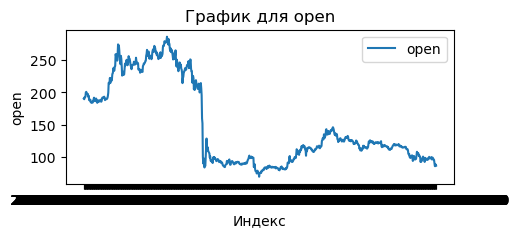


Анализ выбросов:

Выбросы не найдены.
LEAS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


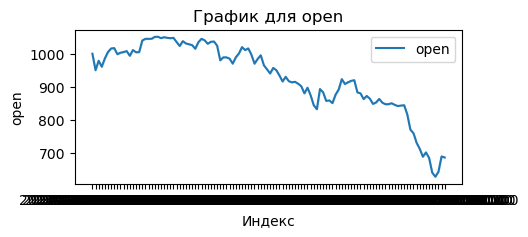


Анализ выбросов:
Найдены выбросы в колонке: open
begin
2024-09-03 00:00:00    627.5
2024-09-03 00:00:00    627.5
Name: open, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
IRAO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


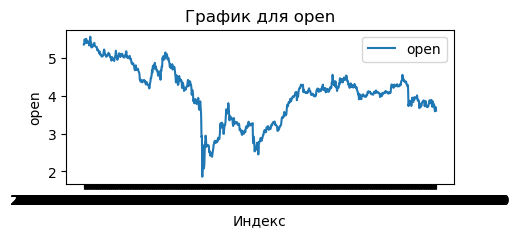


Анализ выбросов:
Найдены выбросы в колонке: open
begin
2021-01-27 00:00:00    5.5555
2022-02-25 00:00:00    1.8615
2022-03-25 00:00:00    2.4900
2022-03-28 00:00:00    2.2920
2022-03-29 00:00:00    2.0820
2022-03-30 00:00:00    2.1875
2022-04-15 00:00:00    2.5100
2022-04-18 00:00:00    2.5415
2022-04-19 00:00:00    2.4500
2022-04-20 00:00:00    2.4150
2022-04-21 00:00:00    2.4950
2022-04-22 00:00:00    2.4300
2022-04-25 00:00:00    2.4300
2022-04-26 00:00:00    2.3880
2022-04-27 00:00:00    2.4605
2022-04-28 00:00:00    2.5300
2022-09-27 00:00:00    2.5300
2022-09-30 00:00:00    2.5680
2022-10-10 00:00:00    2.4500
Name: open, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
MAGN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


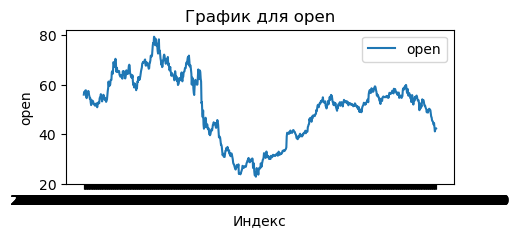


Анализ выбросов:

Выбросы не найдены.
NVTK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


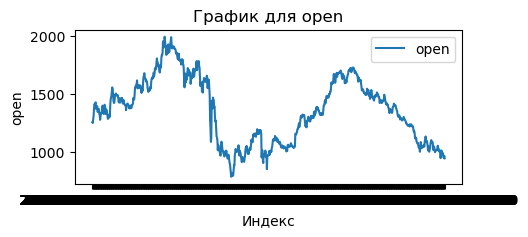


Анализ выбросов:

Выбросы не найдены.
HYDR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


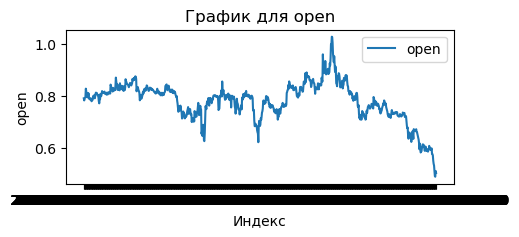


Анализ выбросов:
Найдены выбросы в колонке: open
begin
2023-08-04 00:00:00    0.9603
2023-09-01 00:00:00    0.9985
2023-09-04 00:00:00    0.9957
2023-09-05 00:00:00    1.0280
2023-09-06 00:00:00    1.0270
2023-09-07 00:00:00    1.0050
2023-09-08 00:00:00    0.9627
2023-09-13 00:00:00    0.9530
2024-07-11 00:00:00    0.5960
2024-07-15 00:00:00    0.6057
2024-07-16 00:00:00    0.5836
2024-07-17 00:00:00    0.5868
2024-07-18 00:00:00    0.5881
2024-07-19 00:00:00    0.5999
2024-07-22 00:00:00    0.6050
2024-07-23 00:00:00    0.6146
2024-07-24 00:00:00    0.6129
2024-07-25 00:00:00    0.6133
2024-07-26 00:00:00    0.6103
2024-07-29 00:00:00    0.6010
2024-07-30 00:00:00    0.5900
2024-07-31 00:00:00    0.5945
2024-08-01 00:00:00    0.6064
2024-08-02 00:00:00    0.6000
2024-08-05 00:00:00    0.5900
2024-08-06 00:00:00    0.5920
2024-08-07 00:00:00    0.5903
2024-08-08 00:00:00    0.5961
2024-08-09 00:00:00    0.5868
2024-08-12 00:00:00    0.5925
2024-08-13 00:00:00    0.5944
2024-08-14 00:

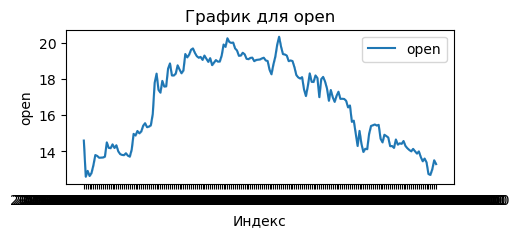


Анализ выбросов:

Выбросы не найдены.
FLOT
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


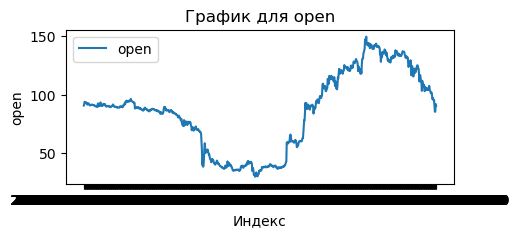


Анализ выбросов:

Выбросы не найдены.
UPRO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


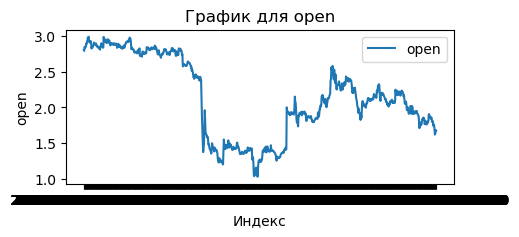


Анализ выбросов:

Выбросы не найдены.
ALRS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


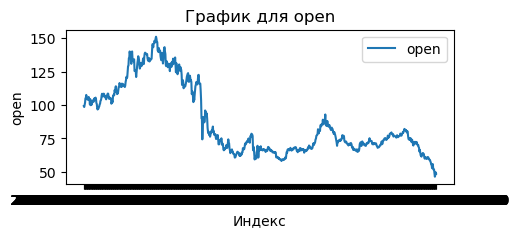


Анализ выбросов:

Выбросы не найдены.
LKOH
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


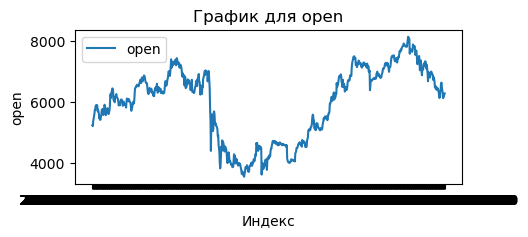


Анализ выбросов:

Выбросы не найдены.
NLMK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


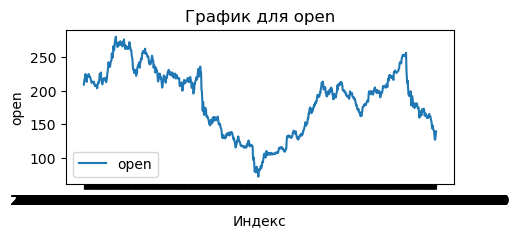


Анализ выбросов:

Выбросы не найдены.
ROSN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


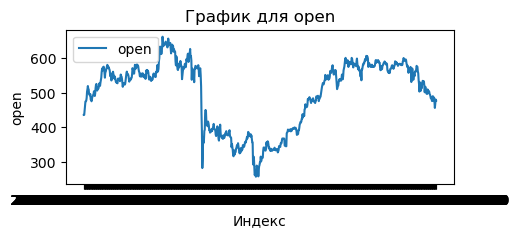


Анализ выбросов:

Выбросы не найдены.
SBER
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


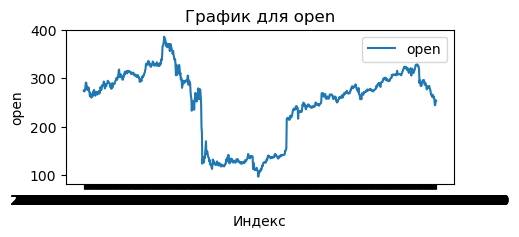


Анализ выбросов:

Выбросы не найдены.
GMKN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


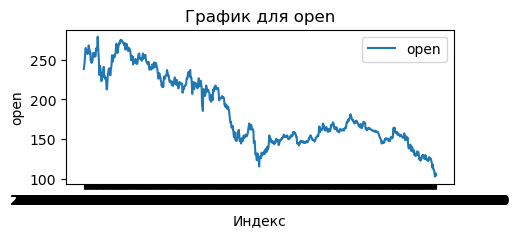


Анализ выбросов:

Выбросы не найдены.
GAZP
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


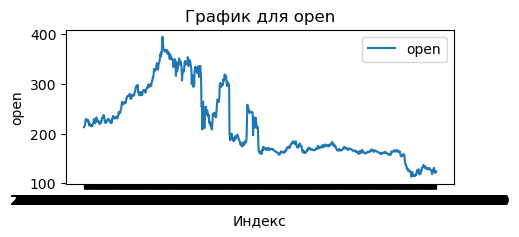


Анализ выбросов:

Выбросы не найдены.
MTSS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


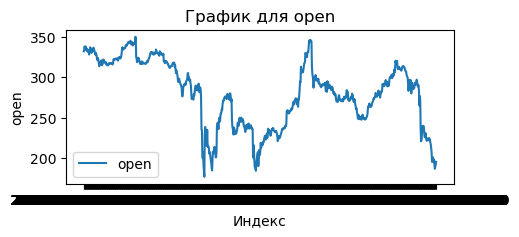


Анализ выбросов:

Выбросы не найдены.
SNGS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


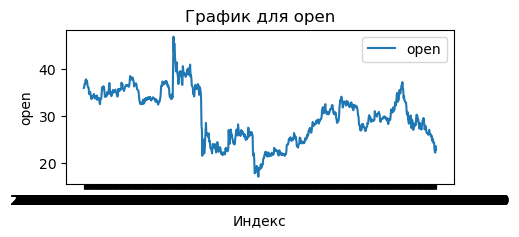


Анализ выбросов:

Выбросы не найдены.
SNGSp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


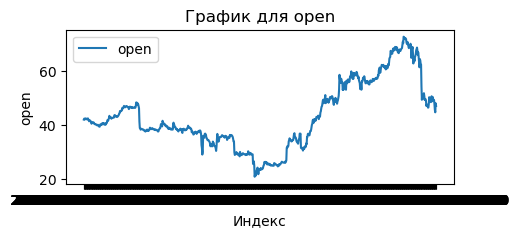


Анализ выбросов:

Выбросы не найдены.
TRNFp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


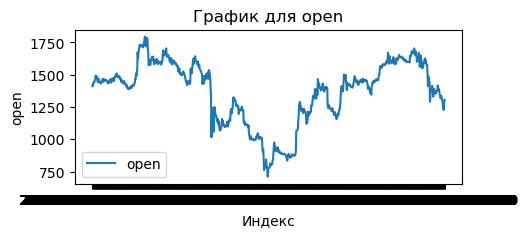


Анализ выбросов:

Выбросы не найдены.
SIBN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


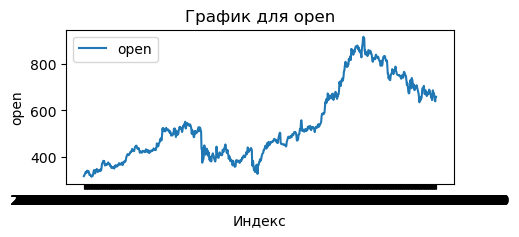


Анализ выбросов:

Выбросы не найдены.
PHOR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


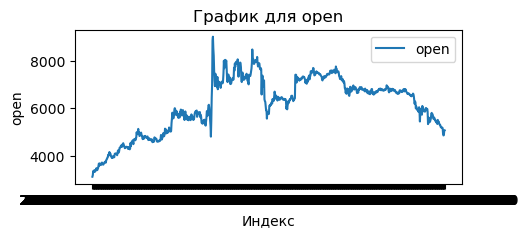


Анализ выбросов:

Выбросы не найдены.
RTKM
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


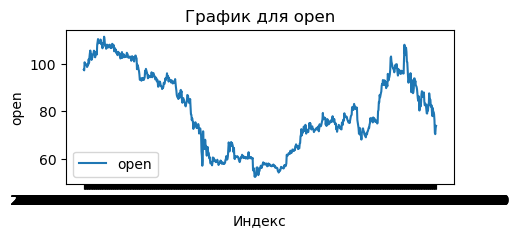


Анализ выбросов:

Выбросы не найдены.
RTKMp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


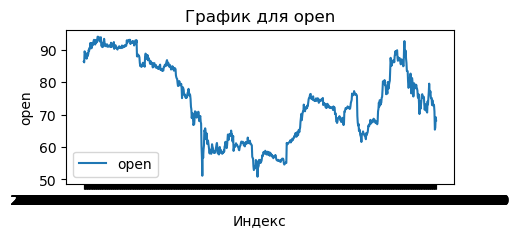


Анализ выбросов:

Выбросы не найдены.
TTLK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


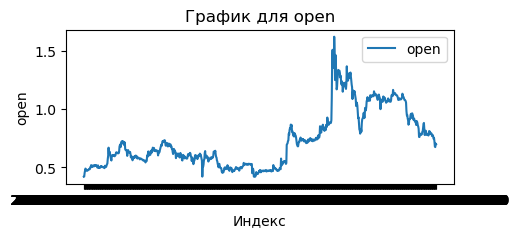


Анализ выбросов:
Найдены выбросы в колонке: open
begin
2023-09-06 00:00:00    1.4400
2023-09-07 00:00:00    1.5100
2023-09-11 00:00:00    1.3705
2023-09-13 00:00:00    1.6220
2023-09-14 00:00:00    1.4950
2023-09-18 00:00:00    1.4660
2023-09-19 00:00:00    1.3800
Name: open, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
MOEX
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


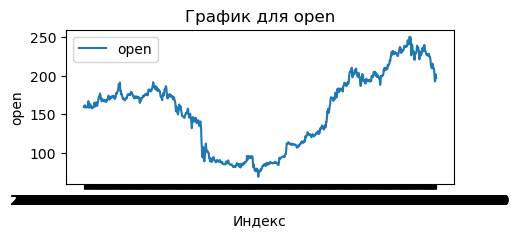


Анализ выбросов:

Выбросы не найдены.
SBERp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


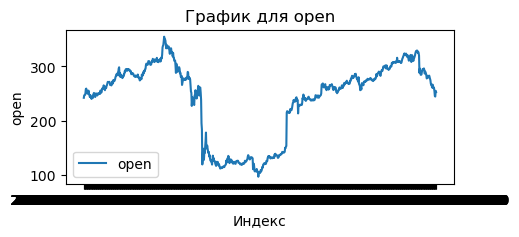


Анализ выбросов:
Найдены выбросы в колонке: open
begin
2022-09-27 00:00:00    106.00
2022-09-28 00:00:00    107.80
2022-09-29 00:00:00    107.00
2022-09-30 00:00:00    105.95
2022-10-03 00:00:00    105.90
2022-10-05 00:00:00    107.20
2022-10-06 00:00:00    104.85
2022-10-07 00:00:00    105.20
2022-10-10 00:00:00     96.10
2022-10-11 00:00:00    103.21
2022-10-12 00:00:00    104.18
2022-10-13 00:00:00    103.11
2022-10-14 00:00:00    102.93
2022-10-17 00:00:00    104.28
2022-10-18 00:00:00    108.50
2022-10-19 00:00:00    106.00
2022-10-20 00:00:00    107.75
Name: open, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
FESH
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


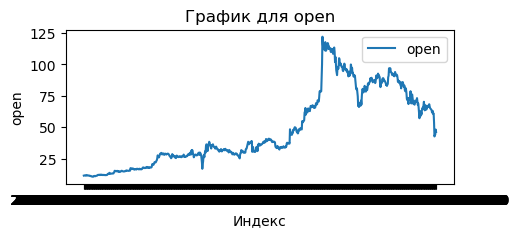


Анализ выбросов:

Выбросы не найдены.
FIVE
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


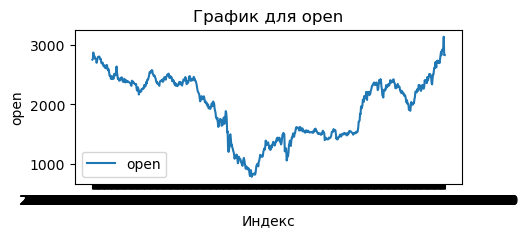


Анализ выбросов:

Выбросы не найдены.
TCSG
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


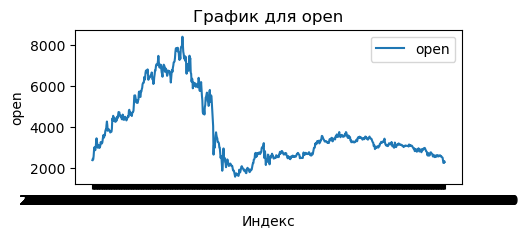


Анализ выбросов:
Найдены выбросы в колонке: open
begin
2021-08-18 00:00:00    7468.8
2021-10-13 00:00:00    7360.0
2021-10-14 00:00:00    7644.0
2021-10-15 00:00:00    7820.0
2021-10-18 00:00:00    7849.8
2021-10-19 00:00:00    7728.0
2021-10-20 00:00:00    7847.8
2021-10-21 00:00:00    7858.2
2021-10-22 00:00:00    7860.6
2021-10-25 00:00:00    7660.0
2021-10-26 00:00:00    7648.8
2021-10-27 00:00:00    7347.8
2021-10-29 00:00:00    7469.0
2021-11-01 00:00:00    7324.8
2021-11-02 00:00:00    7824.8
2021-11-03 00:00:00    7899.0
2021-11-05 00:00:00    7900.0
2021-11-08 00:00:00    8005.0
2021-11-09 00:00:00    8400.0
2021-11-10 00:00:00    7983.6
2021-11-11 00:00:00    7670.0
2021-11-12 00:00:00    7559.0
2021-11-15 00:00:00    7335.0
2021-11-16 00:00:00    7465.0
2021-11-17 00:00:00    7450.0
2021-11-19 00:00:00    7420.0
2021-12-02 00:00:00    7477.0
2021-12-06 00:00:00    7351.8
Name: open, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные дан

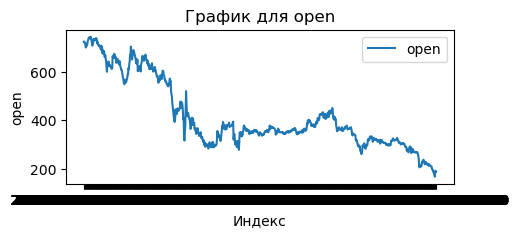


Анализ выбросов:

Выбросы не найдены.
high
VTBR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


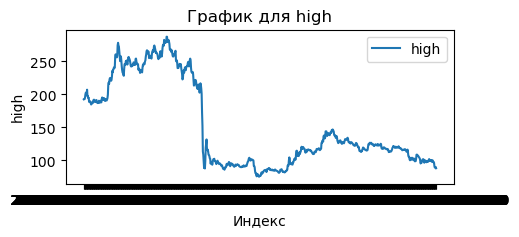


Анализ выбросов:

Выбросы не найдены.
LEAS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


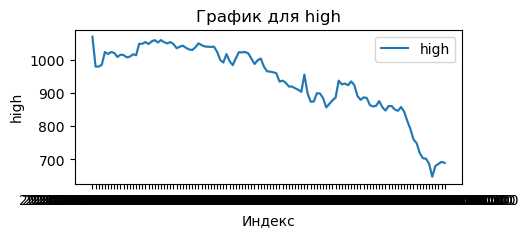


Анализ выбросов:
Найдены выбросы в колонке: high
begin
2024-09-02 00:00:00    647.9
2024-09-02 00:00:00    647.9
Name: high, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
IRAO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


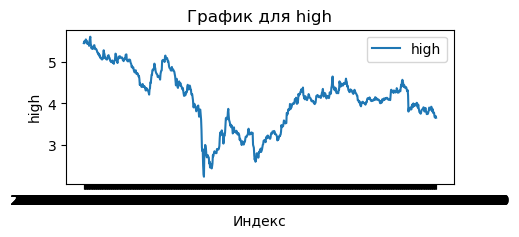


Анализ выбросов:
Найдены выбросы в колонке: high
begin
2021-01-27 00:00:00    5.6100
2022-03-25 00:00:00    2.5000
2022-03-28 00:00:00    2.2920
2022-03-29 00:00:00    2.2300
2022-04-15 00:00:00    2.5500
2022-04-18 00:00:00    2.5945
2022-04-19 00:00:00    2.4530
2022-04-20 00:00:00    2.5490
2022-04-21 00:00:00    2.4950
2022-04-22 00:00:00    2.4785
2022-04-25 00:00:00    2.4300
2022-04-26 00:00:00    2.4760
2022-04-27 00:00:00    2.5470
2022-09-29 00:00:00    2.5910
2022-09-30 00:00:00    2.6180
Name: high, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
MAGN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


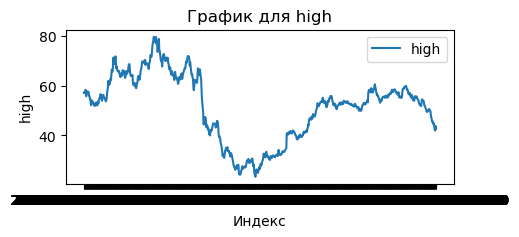


Анализ выбросов:

Выбросы не найдены.
NVTK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


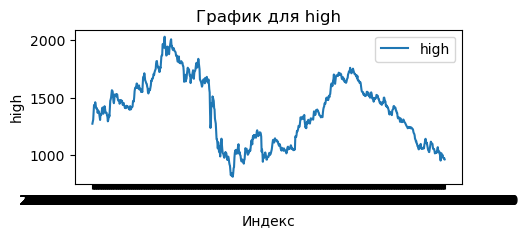


Анализ выбросов:

Выбросы не найдены.
HYDR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


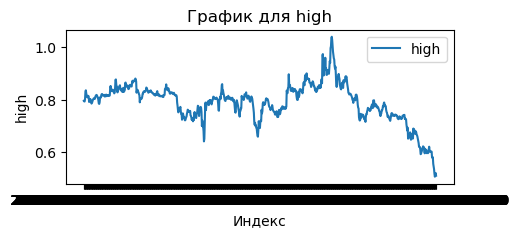


Анализ выбросов:
Найдены выбросы в колонке: high
begin
2023-08-03 00:00:00    0.9691
2023-08-04 00:00:00    0.9738
2023-08-14 00:00:00    0.9597
2023-08-31 00:00:00    0.9966
2023-09-01 00:00:00    1.0037
2023-09-04 00:00:00    1.0344
2023-09-05 00:00:00    1.0400
2023-09-06 00:00:00    1.0272
2023-09-07 00:00:00    1.0051
2023-09-08 00:00:00    0.9828
2023-09-11 00:00:00    0.9684
2023-09-12 00:00:00    0.9579
2024-07-10 00:00:00    0.6196
2024-07-11 00:00:00    0.6195
2024-07-12 00:00:00    0.6190
2024-07-15 00:00:00    0.6099
2024-07-16 00:00:00    0.5915
2024-07-17 00:00:00    0.5933
2024-07-18 00:00:00    0.5998
2024-07-19 00:00:00    0.6039
2024-07-22 00:00:00    0.6143
2024-07-23 00:00:00    0.6148
2024-07-24 00:00:00    0.6216
2024-07-25 00:00:00    0.6136
2024-07-26 00:00:00    0.6177
2024-07-29 00:00:00    0.6043
2024-07-30 00:00:00    0.5949
2024-07-31 00:00:00    0.6123
2024-08-01 00:00:00    0.6084
2024-08-02 00:00:00    0.6049
2024-08-05 00:00:00    0.6075
2024-08-06 00:

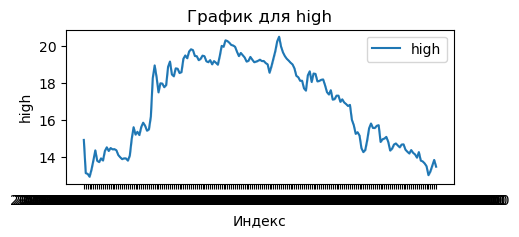


Анализ выбросов:

Выбросы не найдены.
FLOT
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


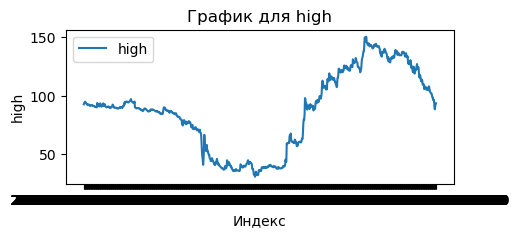


Анализ выбросов:

Выбросы не найдены.
UPRO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


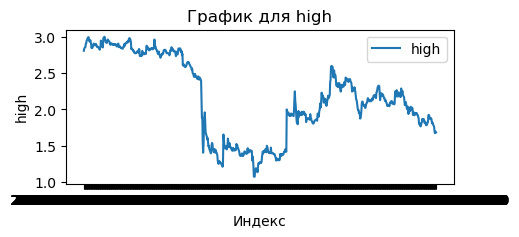


Анализ выбросов:

Выбросы не найдены.
ALRS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


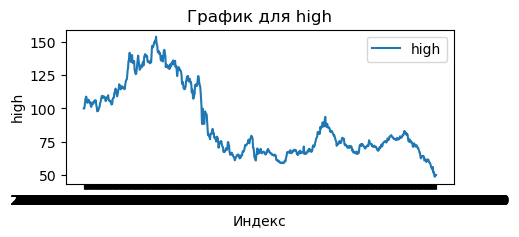


Анализ выбросов:

Выбросы не найдены.
LKOH
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


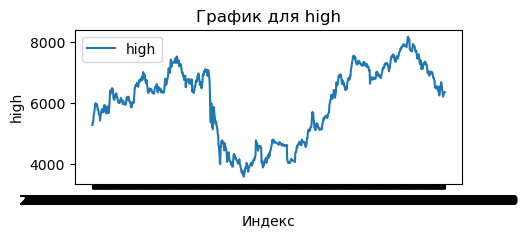


Анализ выбросов:

Выбросы не найдены.
NLMK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


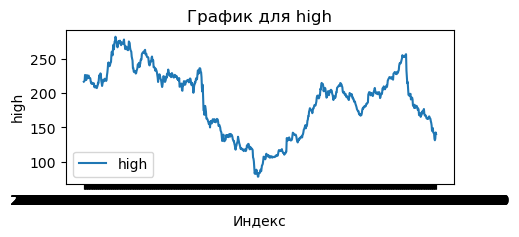


Анализ выбросов:

Выбросы не найдены.
ROSN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


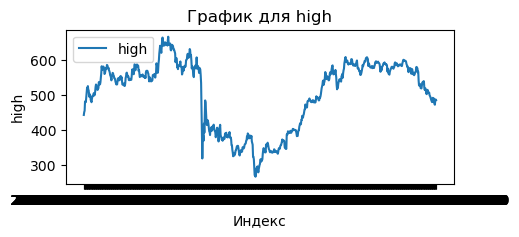


Анализ выбросов:

Выбросы не найдены.
SBER
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


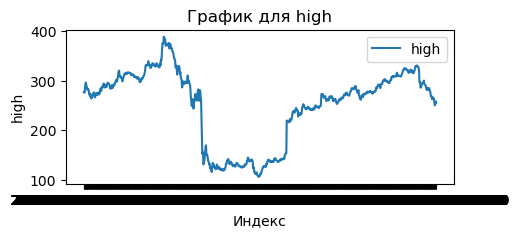


Анализ выбросов:

Выбросы не найдены.
GMKN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


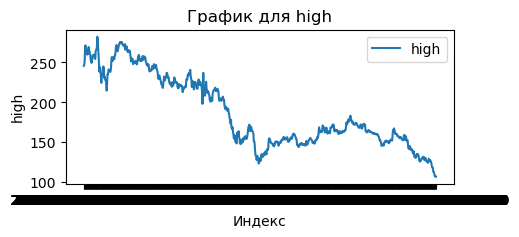


Анализ выбросов:

Выбросы не найдены.
GAZP
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


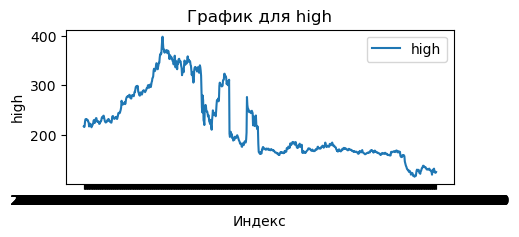


Анализ выбросов:

Выбросы не найдены.
MTSS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


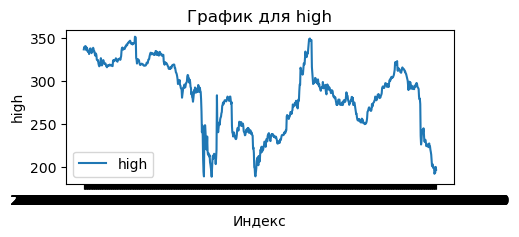


Анализ выбросов:

Выбросы не найдены.
SNGS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


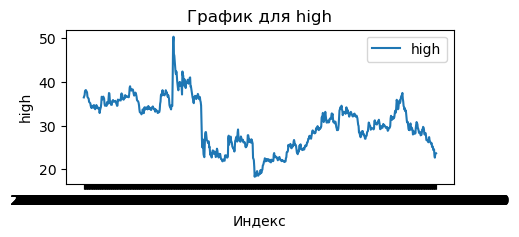


Анализ выбросов:
Найдены выбросы в колонке: high
begin
2021-11-12 00:00:00    49.00
2021-11-15 00:00:00    50.35
Name: high, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
SNGSp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


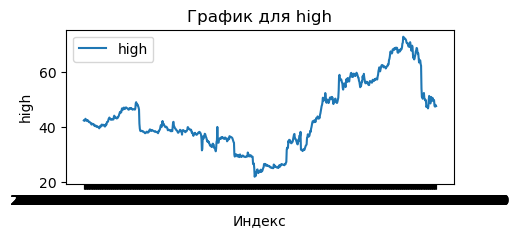


Анализ выбросов:

Выбросы не найдены.
TRNFp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


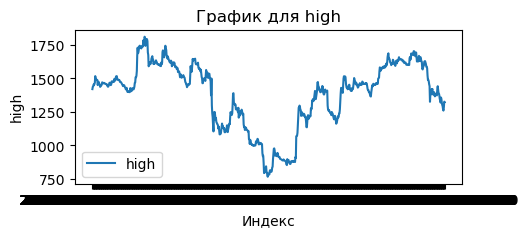


Анализ выбросов:

Выбросы не найдены.
SIBN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


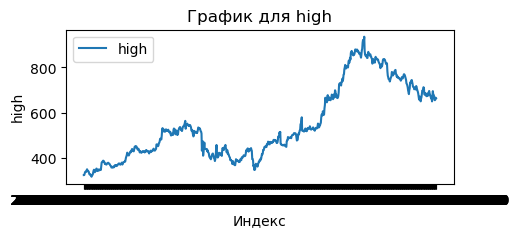


Анализ выбросов:

Выбросы не найдены.
PHOR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


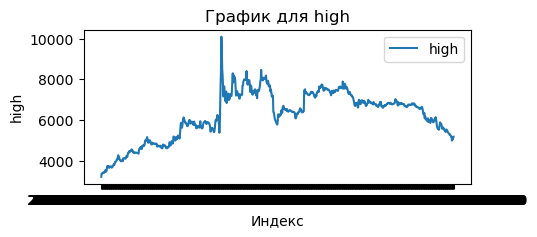


Анализ выбросов:
Найдены выбросы в колонке: high
begin
2022-03-29 00:00:00    10097.0
Name: high, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
RTKM
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


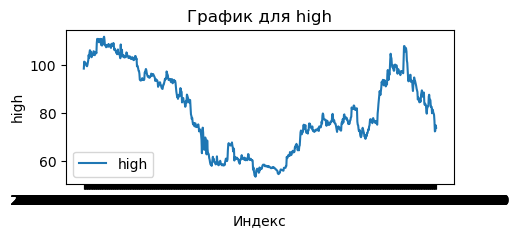


Анализ выбросов:

Выбросы не найдены.
RTKMp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


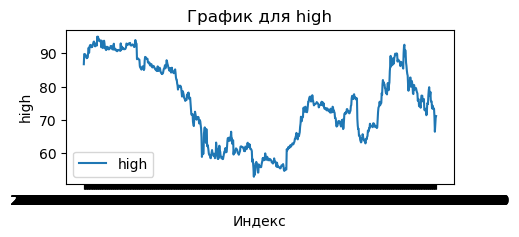


Анализ выбросов:

Выбросы не найдены.
TTLK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


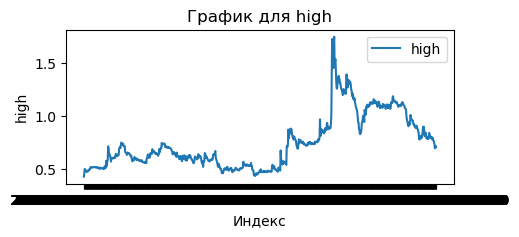


Анализ выбросов:
Найдены выбросы в колонке: high
begin
2023-09-05 00:00:00    1.4445
2023-09-06 00:00:00    1.7300
2023-09-07 00:00:00    1.5895
2023-09-08 00:00:00    1.4740
2023-09-11 00:00:00    1.4545
2023-09-12 00:00:00    1.6895
2023-09-13 00:00:00    1.7515
2023-09-14 00:00:00    1.4950
2023-09-15 00:00:00    1.5175
2023-09-18 00:00:00    1.5400
2023-09-19 00:00:00    1.4250
2023-10-25 00:00:00    1.3950
2023-10-26 00:00:00    1.3925
Name: high, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
MOEX
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


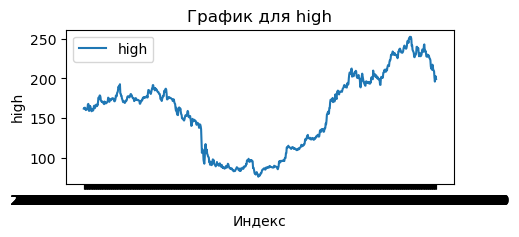


Анализ выбросов:

Выбросы не найдены.
SBERp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


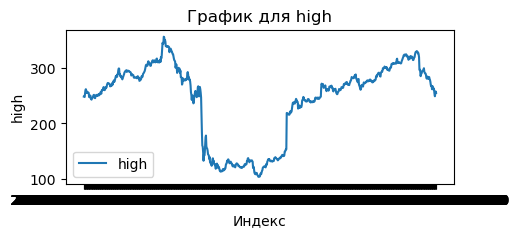


Анализ выбросов:
Найдены выбросы в колонке: high
begin
2022-09-27 00:00:00    109.50
2022-09-29 00:00:00    107.91
2022-09-30 00:00:00    108.30
2022-10-03 00:00:00    109.96
2022-10-05 00:00:00    107.20
2022-10-06 00:00:00    106.50
2022-10-07 00:00:00    105.22
2022-10-10 00:00:00    103.49
2022-10-11 00:00:00    104.19
2022-10-12 00:00:00    104.43
2022-10-13 00:00:00    103.50
2022-10-14 00:00:00    104.56
2022-10-17 00:00:00    108.68
2022-10-18 00:00:00    109.39
2022-10-19 00:00:00    108.10
Name: high, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
FESH
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


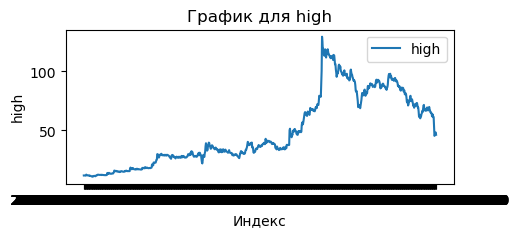


Анализ выбросов:

Выбросы не найдены.
FIVE
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


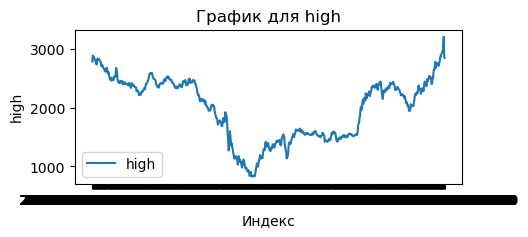


Анализ выбросов:

Выбросы не найдены.
TCSG
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


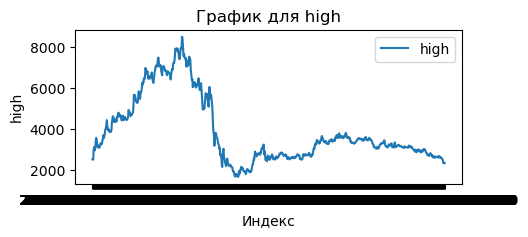


Анализ выбросов:
Найдены выбросы в колонке: high
begin
2021-08-18 00:00:00    7499.0
2021-10-13 00:00:00    7677.6
2021-10-14 00:00:00    7924.6
2021-10-15 00:00:00    7893.8
2021-10-18 00:00:00    7945.2
2021-10-19 00:00:00    7836.6
2021-10-20 00:00:00    7944.0
2021-10-21 00:00:00    7924.2
2021-10-22 00:00:00    7909.8
2021-10-25 00:00:00    7754.0
2021-10-26 00:00:00    7648.8
2021-10-27 00:00:00    7449.2
2021-10-29 00:00:00    7469.0
2021-11-01 00:00:00    7816.0
2021-11-02 00:00:00    7970.0
2021-11-03 00:00:00    7944.0
2021-11-05 00:00:00    8040.2
2021-11-08 00:00:00    8518.4
2021-11-09 00:00:00    8474.2
2021-11-10 00:00:00    8180.0
2021-11-11 00:00:00    7780.0
2021-11-12 00:00:00    7559.0
2021-11-15 00:00:00    7681.8
2021-11-16 00:00:00    7541.8
2021-11-17 00:00:00    7450.0
2021-11-18 00:00:00    7460.0
2021-11-19 00:00:00    7480.0
2021-12-01 00:00:00    7542.2
2021-12-02 00:00:00    7519.6
Name: high, dtype: float64

Выбросы были найдены. Оцените, действительно л

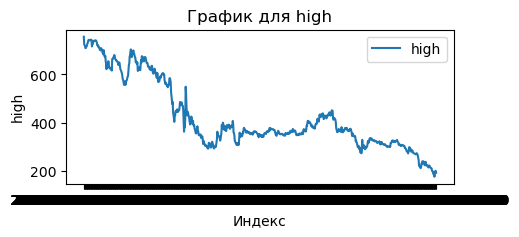


Анализ выбросов:

Выбросы не найдены.
low
VTBR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


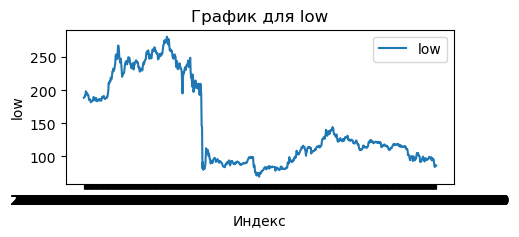


Анализ выбросов:

Выбросы не найдены.
LEAS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


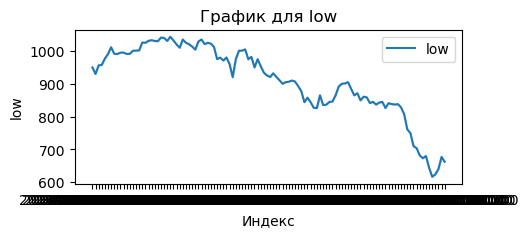


Анализ выбросов:

Выбросы не найдены.
IRAO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


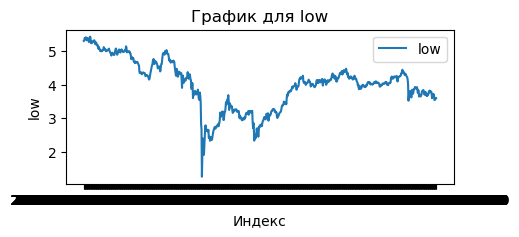


Анализ выбросов:
Найдены выбросы в колонке: low
begin
2022-02-24 00:00:00    1.2550
2022-02-25 00:00:00    1.8615
2022-03-24 00:00:00    2.4000
2022-03-25 00:00:00    2.2100
2022-03-28 00:00:00    2.0800
2022-03-29 00:00:00    1.9100
2022-03-30 00:00:00    2.1875
2022-04-14 00:00:00    2.4100
2022-04-15 00:00:00    2.4100
2022-04-19 00:00:00    2.3300
2022-04-20 00:00:00    2.4120
2022-04-21 00:00:00    2.4345
2022-04-22 00:00:00    2.4010
2022-04-25 00:00:00    2.3500
2022-04-26 00:00:00    2.3750
2022-09-26 00:00:00    2.3340
2022-09-29 00:00:00    2.4030
2022-09-30 00:00:00    2.4345
Name: low, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
MAGN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


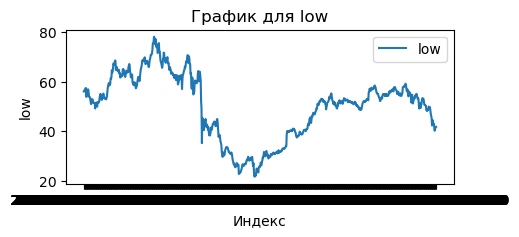


Анализ выбросов:

Выбросы не найдены.
NVTK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


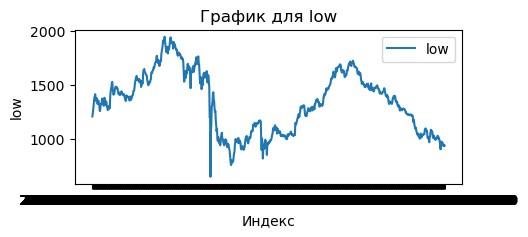


Анализ выбросов:

Выбросы не найдены.
HYDR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


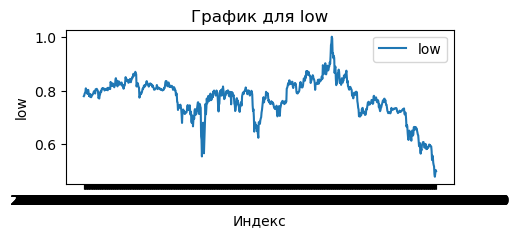


Анализ выбросов:
Найдены выбросы в колонке: low
begin
2022-02-24 00:00:00    0.5532
2022-03-29 00:00:00    0.5650
2023-09-01 00:00:00    0.9700
2023-09-04 00:00:00    0.9776
2023-09-05 00:00:00    1.0013
2023-09-06 00:00:00    0.9950
2024-07-10 00:00:00    0.5915
2024-07-11 00:00:00    0.5923
2024-07-15 00:00:00    0.5754
2024-07-16 00:00:00    0.5637
2024-07-17 00:00:00    0.5810
2024-07-18 00:00:00    0.5755
2024-07-19 00:00:00    0.5947
2024-07-29 00:00:00    0.5866
2024-07-30 00:00:00    0.5857
2024-07-31 00:00:00    0.5913
2024-08-02 00:00:00    0.5960
2024-08-05 00:00:00    0.5805
2024-08-06 00:00:00    0.5829
2024-08-07 00:00:00    0.5818
2024-08-08 00:00:00    0.5868
2024-08-09 00:00:00    0.5868
2024-08-12 00:00:00    0.5865
2024-08-13 00:00:00    0.5936
2024-08-14 00:00:00    0.5979
2024-08-15 00:00:00    0.5968
2024-08-16 00:00:00    0.5926
2024-08-19 00:00:00    0.5941
2024-08-20 00:00:00    0.5914
2024-08-21 00:00:00    0.5905
2024-08-22 00:00:00    0.5735
2024-08-23 00:0

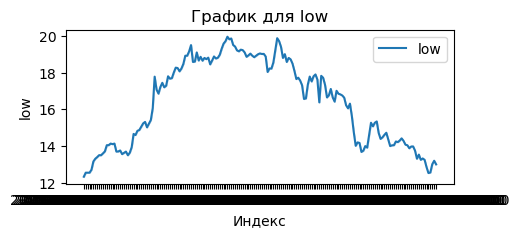


Анализ выбросов:

Выбросы не найдены.
FLOT
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


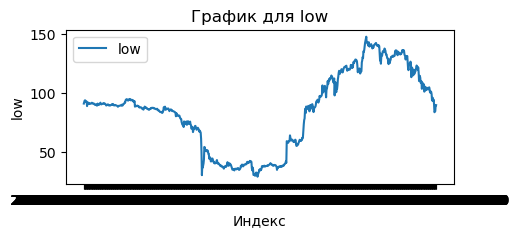


Анализ выбросов:

Выбросы не найдены.
UPRO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


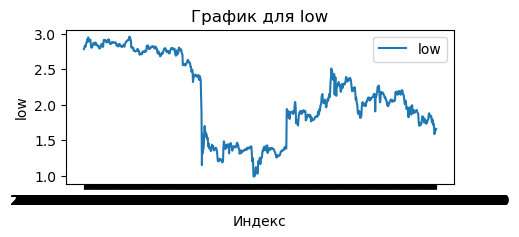


Анализ выбросов:

Выбросы не найдены.
ALRS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


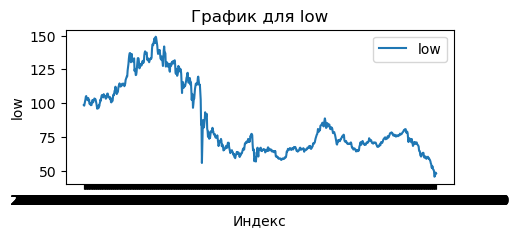


Анализ выбросов:

Выбросы не найдены.
LKOH
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


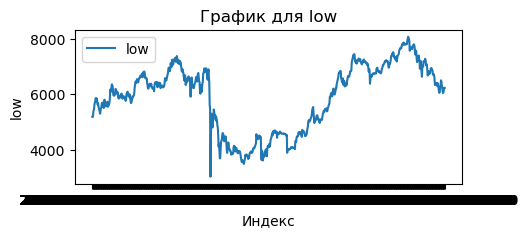


Анализ выбросов:

Выбросы не найдены.
NLMK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


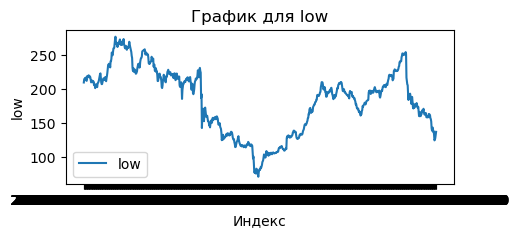


Анализ выбросов:

Выбросы не найдены.
ROSN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


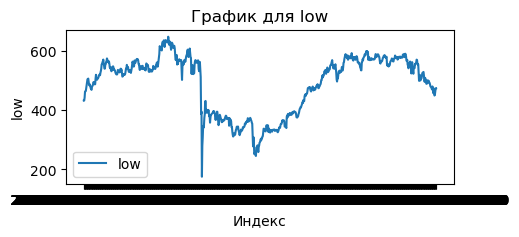


Анализ выбросов:

Выбросы не найдены.
SBER
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


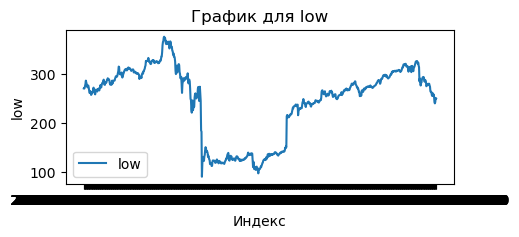


Анализ выбросов:

Выбросы не найдены.
GMKN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


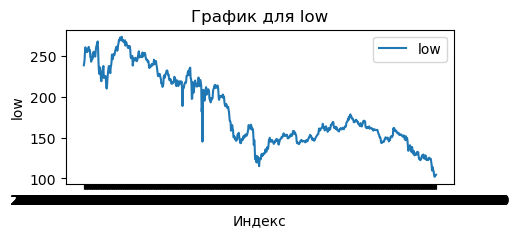


Анализ выбросов:

Выбросы не найдены.
GAZP
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


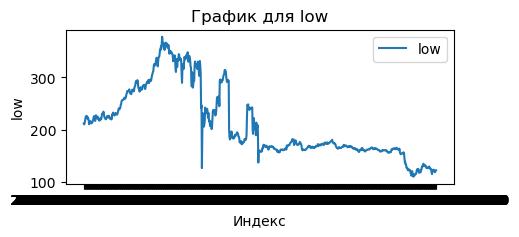


Анализ выбросов:

Выбросы не найдены.
MTSS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


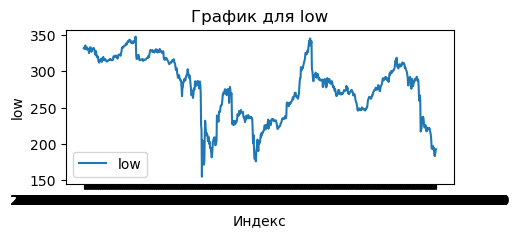


Анализ выбросов:

Выбросы не найдены.
SNGS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


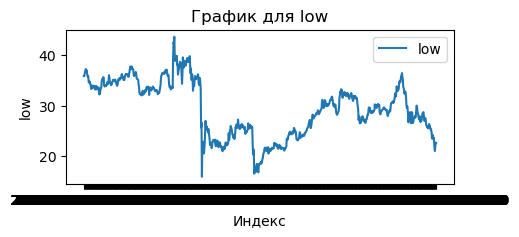


Анализ выбросов:

Выбросы не найдены.
SNGSp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


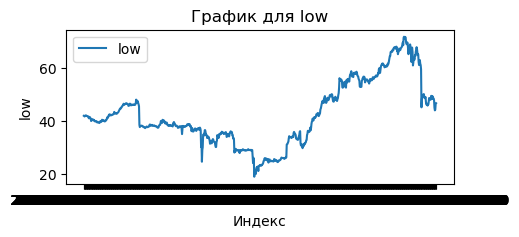


Анализ выбросов:
Найдены выбросы в колонке: low
begin
2024-05-16 00:00:00    71.535
2024-05-17 00:00:00    71.920
2024-05-21 00:00:00    71.445
2024-05-22 00:00:00    71.840
2024-05-23 00:00:00    71.550
Name: low, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
TRNFp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


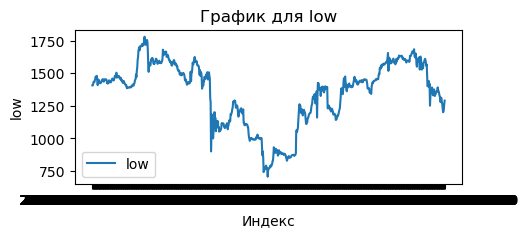


Анализ выбросов:

Выбросы не найдены.
SIBN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


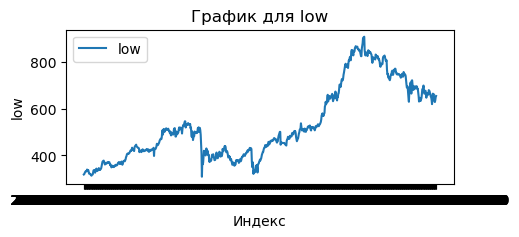


Анализ выбросов:

Выбросы не найдены.
PHOR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


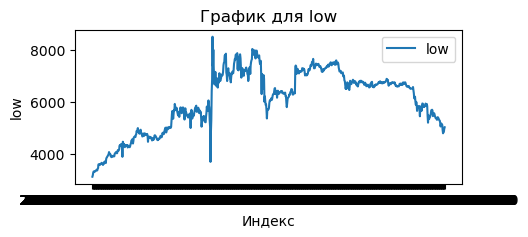


Анализ выбросов:

Выбросы не найдены.
RTKM
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


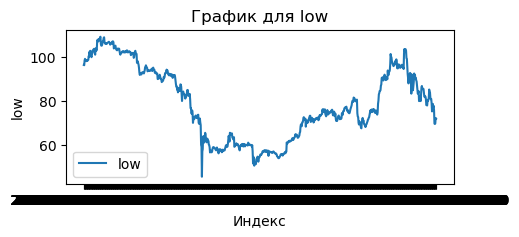


Анализ выбросов:

Выбросы не найдены.
RTKMp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


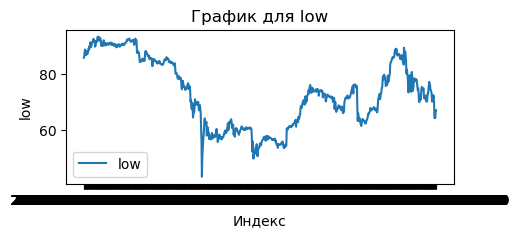


Анализ выбросов:

Выбросы не найдены.
TTLK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


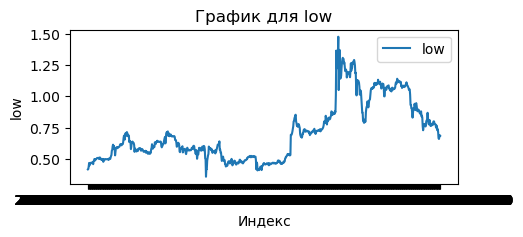


Анализ выбросов:
Найдены выбросы в колонке: low
begin
2023-09-06 00:00:00    1.3640
2023-09-12 00:00:00    1.3400
2023-09-13 00:00:00    1.4745
2023-09-18 00:00:00    1.3700
Name: low, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
MOEX
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


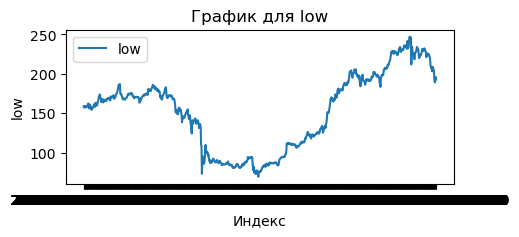


Анализ выбросов:

Выбросы не найдены.
SBERp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


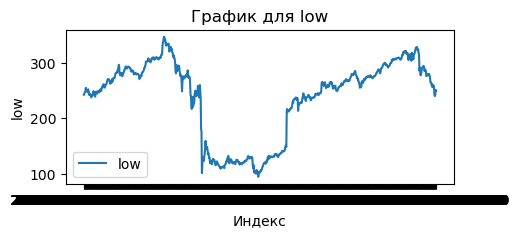


Анализ выбросов:
Найдены выбросы в колонке: low
begin
2022-02-24 00:00:00    101.00
2022-09-26 00:00:00    102.00
2022-09-27 00:00:00    104.00
2022-09-28 00:00:00    104.65
2022-09-29 00:00:00    102.19
2022-09-30 00:00:00    100.00
2022-10-03 00:00:00    105.19
2022-10-04 00:00:00    106.61
2022-10-05 00:00:00    103.16
2022-10-06 00:00:00    104.45
2022-10-07 00:00:00     98.50
2022-10-10 00:00:00     94.50
2022-10-11 00:00:00    100.38
2022-10-12 00:00:00    102.43
2022-10-13 00:00:00    102.10
2022-10-14 00:00:00    102.00
2022-10-17 00:00:00    103.90
2022-10-18 00:00:00    106.16
2022-10-19 00:00:00    105.01
Name: low, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
FESH
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


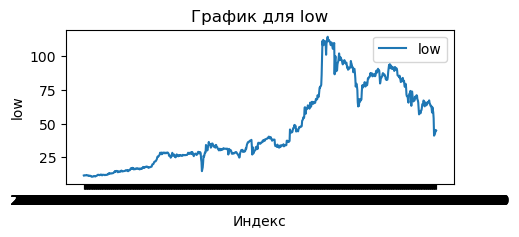


Анализ выбросов:

Выбросы не найдены.
FIVE
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


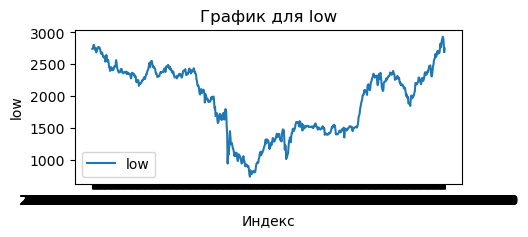


Анализ выбросов:

Выбросы не найдены.
TCSG
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


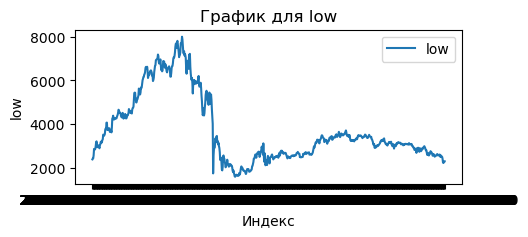


Анализ выбросов:
Найдены выбросы в колонке: low
begin
2021-08-17 00:00:00    7188.0
2021-08-18 00:00:00    7120.0
2021-10-12 00:00:00    7132.8
2021-10-13 00:00:00    7290.0
2021-10-14 00:00:00    7542.2
2021-10-15 00:00:00    7678.6
2021-10-18 00:00:00    7700.2
2021-10-19 00:00:00    7485.2
2021-10-20 00:00:00    7770.0
2021-10-21 00:00:00    7815.2
2021-10-22 00:00:00    7642.4
2021-10-25 00:00:00    7500.0
2021-10-26 00:00:00    7300.0
2021-10-28 00:00:00    7208.0
2021-10-29 00:00:00    7185.4
2021-11-01 00:00:00    7304.2
2021-11-02 00:00:00    7700.0
2021-11-03 00:00:00    7702.0
2021-11-05 00:00:00    7760.0
2021-11-08 00:00:00    8005.0
2021-11-09 00:00:00    7876.6
2021-11-10 00:00:00    7605.0
2021-11-11 00:00:00    7312.0
2021-11-12 00:00:00    7230.0
2021-11-15 00:00:00    7335.0
2021-11-16 00:00:00    7142.4
2021-11-17 00:00:00    7217.0
2021-11-18 00:00:00    7150.0
2021-12-01 00:00:00    7175.0
2021-12-02 00:00:00    7175.4
2021-12-03 00:00:00    7220.0
Name: low, dtyp

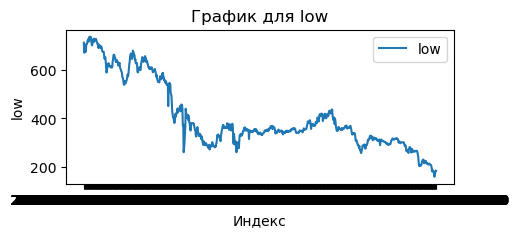


Анализ выбросов:
Найдены выбросы в колонке: low
begin
2021-03-10 00:00:00    712.2
2021-03-12 00:00:00    701.1
2021-03-15 00:00:00    703.6
2021-03-16 00:00:00    696.0
2021-03-17 00:00:00    674.7
2021-03-18 00:00:00    706.0
2021-03-19 00:00:00    706.0
2021-03-22 00:00:00    708.2
2021-03-23 00:00:00    718.0
2021-03-24 00:00:00    723.1
2021-03-25 00:00:00    727.2
2021-03-26 00:00:00    717.0
2021-03-29 00:00:00    733.4
2021-03-30 00:00:00    736.4
2021-03-31 00:00:00    732.9
2021-04-01 00:00:00    736.8
2021-04-02 00:00:00    736.0
2021-04-05 00:00:00    721.6
2021-04-06 00:00:00    710.0
2021-04-07 00:00:00    701.0
2021-04-08 00:00:00    705.0
2021-04-09 00:00:00    715.0
2021-04-12 00:00:00    718.0
2021-04-13 00:00:00    728.0
2021-04-14 00:00:00    715.1
2021-04-15 00:00:00    728.2
2021-04-16 00:00:00    720.2
2021-04-19 00:00:00    723.5
2021-04-20 00:00:00    727.0
2021-04-21 00:00:00    727.5
2021-04-22 00:00:00    722.2
2021-04-23 00:00:00    716.2
2021-04-26 00:00:

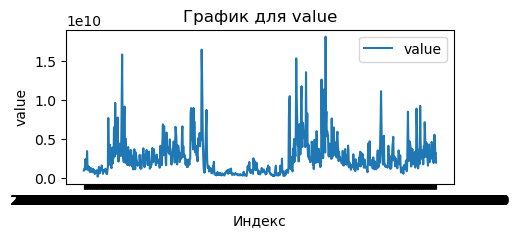


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-03-31 00:00:00    7.675764e+09
2021-04-23 00:00:00    9.618114e+09
2021-05-04 00:00:00    7.728792e+09
2021-05-18 00:00:00    1.024837e+10
2021-05-19 00:00:00    1.584971e+10
2021-05-26 00:00:00    8.034091e+09
2021-05-27 00:00:00    9.142050e+09
2021-10-06 00:00:00    6.851172e+09
2022-01-13 00:00:00    8.285207e+09
2022-01-14 00:00:00    8.951159e+09
2022-01-18 00:00:00    7.012527e+09
2022-01-24 00:00:00    8.968965e+09
2022-01-26 00:00:00    7.246333e+09
2022-02-21 00:00:00    1.646875e+10
2022-02-22 00:00:00    1.343151e+10
2022-02-24 00:00:00    8.851098e+09
2022-04-04 00:00:00    7.255904e+09
2022-04-05 00:00:00    8.714064e+09
2023-04-03 00:00:00    7.758018e+09
2023-04-04 00:00:00    9.897463e+09
2023-04-05 00:00:00    1.048851e+10
2023-04-27 00:00:00    1.534755e+10
2023-04-28 00:00:00    1.043706e+10
2023-05-02 00:00:00    8.174368e+09
2023-05-11 00:00:00    6.882076e+09
2023-05-17 00:00:00    1.000340e+10
2023-05

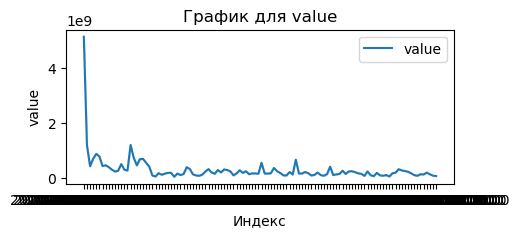


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2024-03-29 00:00:00    5.139558e+09
2024-04-01 00:00:00    1.192824e+09
2024-04-03 00:00:00    7.019620e+08
2024-04-04 00:00:00    8.768882e+08
2024-04-05 00:00:00    7.813312e+08
2024-04-19 00:00:00    1.199204e+09
2024-04-22 00:00:00    7.351544e+08
2024-04-24 00:00:00    6.853521e+08
2024-04-25 00:00:00    6.902951e+08
2024-04-26 00:00:00    5.479593e+08
2024-06-20 00:00:00    5.512940e+08
2024-07-05 00:00:00    6.638839e+08
2024-03-29 00:00:00    5.139558e+09
2024-04-01 00:00:00    1.192824e+09
2024-04-03 00:00:00    7.019620e+08
2024-04-04 00:00:00    8.768882e+08
2024-04-05 00:00:00    7.813312e+08
2024-04-19 00:00:00    1.199204e+09
2024-04-22 00:00:00    7.351544e+08
2024-04-24 00:00:00    6.853521e+08
2024-04-25 00:00:00    6.902951e+08
2024-04-26 00:00:00    5.479593e+08
2024-06-20 00:00:00    5.512940e+08
2024-07-05 00:00:00    6.638839e+08
Name: value, dtype: float64

Выбросы были найдены. Оцените, действительно ли эт

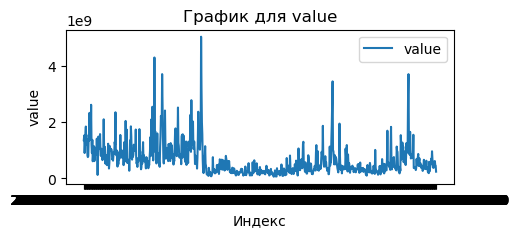


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-12 00:00:00    1.843255e+09
2021-01-25 00:00:00    2.329575e+09
2021-01-27 00:00:00    1.951594e+09
2021-01-29 00:00:00    2.615594e+09
2021-03-16 00:00:00    2.100364e+09
2021-04-26 00:00:00    2.350040e+09
2021-06-01 00:00:00    2.042388e+09
2021-06-04 00:00:00    1.733577e+09
2021-06-18 00:00:00    1.849905e+09
2021-07-06 00:00:00    1.737400e+09
2021-07-19 00:00:00    1.750859e+09
2021-08-27 00:00:00    2.093808e+09
2021-09-01 00:00:00    2.545418e+09
2021-09-08 00:00:00    4.294689e+09
2021-09-30 00:00:00    2.221919e+09
2021-10-01 00:00:00    2.003043e+09
2021-10-04 00:00:00    2.006545e+09
2021-10-05 00:00:00    3.704480e+09
2021-10-06 00:00:00    2.623068e+09
2021-10-14 00:00:00    2.411901e+09
2021-11-19 00:00:00    1.700577e+09
2021-11-22 00:00:00    1.776816e+09
2021-11-30 00:00:00    2.518088e+09
2022-01-14 00:00:00    2.264521e+09
2022-01-18 00:00:00    2.779268e+09
2022-01-24 00:00:00    2.021627e+09
2022-02

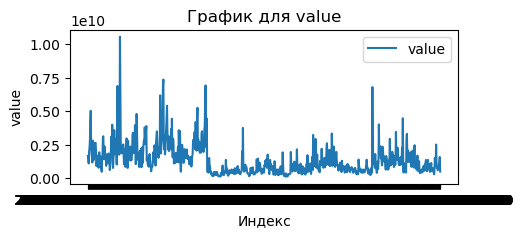


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-13 00:00:00    4.230750e+09
2021-01-14 00:00:00    5.016806e+09
2021-03-31 00:00:00    3.981010e+09
2021-04-19 00:00:00    6.867902e+09
2021-04-21 00:00:00    4.357687e+09
2021-04-27 00:00:00    1.054052e+10
2021-04-28 00:00:00    6.041620e+09
2021-06-18 00:00:00    3.951747e+09
2021-06-24 00:00:00    4.784742e+09
2021-07-22 00:00:00    3.780719e+09
2021-07-28 00:00:00    3.881100e+09
2021-09-14 00:00:00    6.172147e+09
2021-09-21 00:00:00    4.619611e+09
2021-09-22 00:00:00    5.232369e+09
2021-09-23 00:00:00    6.920352e+09
2021-09-24 00:00:00    7.347386e+09
2021-10-05 00:00:00    3.749711e+09
2021-10-06 00:00:00    4.646332e+09
2021-10-07 00:00:00    5.399163e+09
2021-10-21 00:00:00    3.654895e+09
2021-10-25 00:00:00    4.427562e+09
2022-01-18 00:00:00    4.175166e+09
2022-01-19 00:00:00    4.120879e+09
2022-01-24 00:00:00    4.449027e+09
2022-01-25 00:00:00    5.242602e+09
2022-02-18 00:00:00    3.938567e+09
2022-02

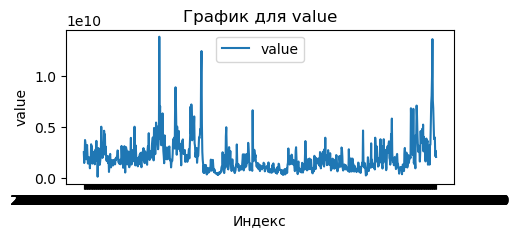


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-03-05 00:00:00    5.030409e+09
2021-07-01 00:00:00    5.029266e+09
2021-09-07 00:00:00    4.906452e+09
2021-09-14 00:00:00    5.433809e+09
2021-09-16 00:00:00    5.067124e+09
2021-09-17 00:00:00    5.002865e+09
2021-09-24 00:00:00    1.384119e+10
2021-09-27 00:00:00    6.295124e+09
2021-09-28 00:00:00    7.038528e+09
2021-09-30 00:00:00    5.452495e+09
2021-10-06 00:00:00    6.334783e+09
2021-11-19 00:00:00    7.231109e+09
2021-11-22 00:00:00    8.888891e+09
2021-11-23 00:00:00    7.273326e+09
2021-11-26 00:00:00    5.038803e+09
2022-01-14 00:00:00    6.995729e+09
2022-01-18 00:00:00    7.208582e+09
2022-01-19 00:00:00    5.999261e+09
2022-01-24 00:00:00    5.678461e+09
2022-01-26 00:00:00    4.848430e+09
2022-01-27 00:00:00    6.036248e+09
2022-02-17 00:00:00    4.806100e+09
2022-02-21 00:00:00    1.028352e+10
2022-02-22 00:00:00    1.243634e+10
2022-02-24 00:00:00    5.250059e+09
2022-06-21 00:00:00    4.977542e+09
2022-09

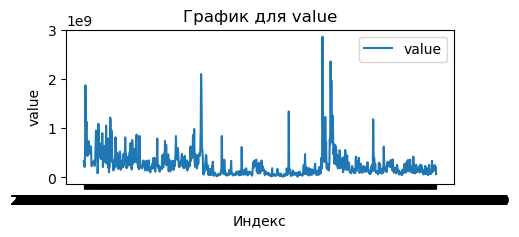


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-11 00:00:00    1.872597e+09
2021-01-12 00:00:00    1.101313e+09
2021-01-13 00:00:00    9.779075e+08
2021-01-14 00:00:00    1.130510e+09
2021-01-21 00:00:00    7.379213e+08
2021-02-16 00:00:00    9.523883e+08
2021-02-17 00:00:00    8.045095e+08
2021-02-19 00:00:00    6.632672e+08
2021-02-24 00:00:00    1.090420e+09
2021-03-02 00:00:00    6.843997e+08
2021-03-10 00:00:00    8.851495e+08
2021-03-11 00:00:00    8.997974e+08
2021-03-24 00:00:00    1.054479e+09
2021-03-29 00:00:00    6.862405e+08
2021-03-30 00:00:00    7.930460e+08
2021-04-07 00:00:00    1.215504e+09
2021-04-08 00:00:00    1.153908e+09
2021-04-13 00:00:00    9.457931e+08
2021-04-26 00:00:00    8.173297e+08
2021-05-31 00:00:00    8.139754e+08
2021-06-17 00:00:00    6.990176e+08
2021-06-23 00:00:00    7.615567e+08
2021-06-24 00:00:00    7.068375e+08
2021-07-07 00:00:00    7.919625e+08
2021-07-08 00:00:00    8.691504e+08
2021-07-19 00:00:00    8.448323e+08
2021-09

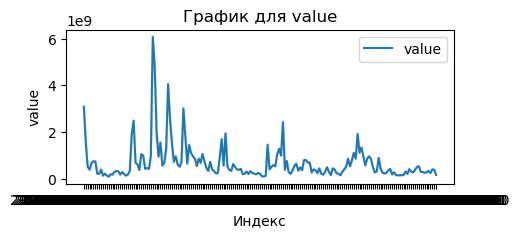


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2023-12-15 00:00:00    3.084381e+09
2023-12-18 00:00:00    1.578801e+09
2024-01-23 00:00:00    1.910240e+09
2024-01-24 00:00:00    2.490609e+09
2024-02-07 00:00:00    6.080005e+09
2024-02-08 00:00:00    4.827178e+09
2024-02-09 00:00:00    1.979657e+09
2024-02-19 00:00:00    4.054226e+09
2024-02-20 00:00:00    2.562281e+09
2024-03-01 00:00:00    3.013897e+09
2024-03-04 00:00:00    1.860515e+09
2024-04-01 00:00:00    1.701576e+09
2024-04-03 00:00:00    1.945061e+09
2024-05-16 00:00:00    2.429518e+09
2024-07-11 00:00:00    1.921125e+09
2023-12-15 00:00:00    3.084381e+09
2023-12-18 00:00:00    1.578801e+09
2024-01-23 00:00:00    1.910240e+09
2024-01-24 00:00:00    2.490609e+09
2024-02-07 00:00:00    6.080005e+09
2024-02-08 00:00:00    4.827178e+09
2024-02-09 00:00:00    1.979657e+09
2024-02-19 00:00:00    4.054226e+09
2024-02-20 00:00:00    2.562281e+09
2024-03-01 00:00:00    3.013897e+09
2024-03-04 00:00:00    1.860515e+09
2024-04

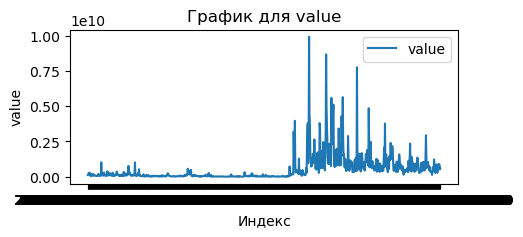


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2023-04-07 00:00:00    3.201270e+09
2023-04-12 00:00:00    3.962653e+09
2023-05-26 00:00:00    2.699548e+09
2023-05-29 00:00:00    3.678714e+09
2023-05-30 00:00:00    3.798470e+09
                           ...     
2024-03-22 00:00:00    2.172816e+09
2024-03-25 00:00:00    1.805576e+09
2024-04-16 00:00:00    1.590712e+09
2024-05-24 00:00:00    2.354230e+09
2024-07-19 00:00:00    2.938632e+09
Name: value, Length: 67, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
UPRO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


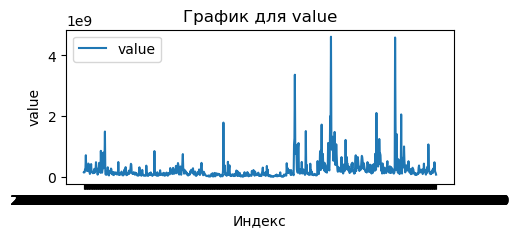


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-12 00:00:00    7.203041e+08
2021-03-04 00:00:00    8.646565e+08
2021-03-15 00:00:00    8.084738e+08
2021-03-18 00:00:00    5.292000e+08
2021-03-19 00:00:00    1.499778e+09
                           ...     
2024-05-13 00:00:00    6.330461e+08
2024-05-17 00:00:00    1.008335e+09
2024-05-20 00:00:00    5.414372e+08
2024-06-03 00:00:00    5.231364e+08
2024-08-12 00:00:00    1.075156e+09
Name: value, Length: 74, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
ALRS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


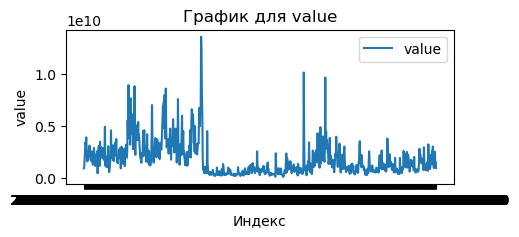


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-06-08 00:00:00    5.535571e+09
2021-06-10 00:00:00    8.943870e+09
2021-06-11 00:00:00    5.235638e+09
2021-06-14 00:00:00    5.620253e+09
2021-06-15 00:00:00    5.355397e+09
2021-06-17 00:00:00    7.194283e+09
2021-06-18 00:00:00    7.672567e+09
2021-06-23 00:00:00    6.118748e+09
2021-06-29 00:00:00    5.378323e+09
2021-07-01 00:00:00    8.847423e+09
2021-07-08 00:00:00    5.062986e+09
2021-07-14 00:00:00    5.381284e+09
2021-08-31 00:00:00    7.024433e+09
2021-10-06 00:00:00    5.936491e+09
2021-10-07 00:00:00    6.950914e+09
2021-10-11 00:00:00    7.315789e+09
2021-10-12 00:00:00    6.069147e+09
2021-10-13 00:00:00    7.991854e+09
2021-10-15 00:00:00    6.288388e+09
2021-10-18 00:00:00    8.620019e+09
2021-11-12 00:00:00    5.654963e+09
2021-11-30 00:00:00    7.596389e+09
2021-12-14 00:00:00    5.982235e+09
2022-01-18 00:00:00    5.278539e+09
2022-01-19 00:00:00    6.622535e+09
2022-01-20 00:00:00    6.154614e+09
2022-01

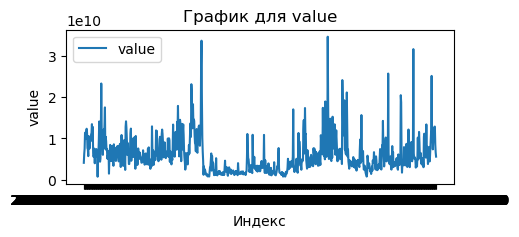


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-03-05 00:00:00    2.338099e+10
2021-03-19 00:00:00    1.756388e+10
2021-11-30 00:00:00    1.792413e+10
2022-01-18 00:00:00    2.320691e+10
2022-01-19 00:00:00    2.088599e+10
2022-01-24 00:00:00    1.833532e+10
2022-01-26 00:00:00    1.464313e+10
2022-02-21 00:00:00    2.780425e+10
2022-02-22 00:00:00    3.379690e+10
2022-02-24 00:00:00    1.944232e+10
2023-04-20 00:00:00    1.708630e+10
2023-06-02 00:00:00    1.741255e+10
2023-08-04 00:00:00    1.745789e+10
2023-08-14 00:00:00    1.900404e+10
2023-08-22 00:00:00    3.476362e+10
2023-08-23 00:00:00    1.917894e+10
2023-08-30 00:00:00    1.480832e+10
2023-09-07 00:00:00    1.529315e+10
2023-10-11 00:00:00    2.421187e+10
2023-10-12 00:00:00    1.915687e+10
2023-10-18 00:00:00    1.928754e+10
2023-10-26 00:00:00    2.119915e+10
2023-12-15 00:00:00    1.569499e+10
2024-03-22 00:00:00    2.579819e+10
2024-05-06 00:00:00    2.053683e+10
2024-05-07 00:00:00    1.876852e+10
2024-06

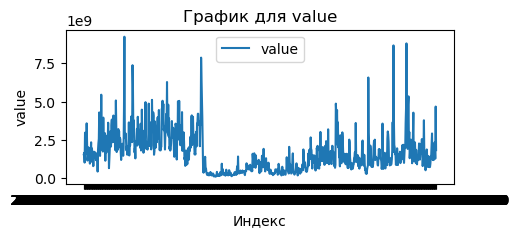


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-03-05 00:00:00    5.444025e+09
2021-04-27 00:00:00    5.068706e+09
2021-05-27 00:00:00    9.226855e+09
2021-06-24 00:00:00    7.369509e+09
2021-06-25 00:00:00    6.098195e+09
2021-08-09 00:00:00    4.957714e+09
2021-08-19 00:00:00    4.862644e+09
2021-08-31 00:00:00    5.108131e+09
2021-10-05 00:00:00    4.606442e+09
2021-10-06 00:00:00    5.049539e+09
2021-10-08 00:00:00    4.840653e+09
2021-10-21 00:00:00    6.271978e+09
2021-10-26 00:00:00    4.794527e+09
2021-11-30 00:00:00    5.016285e+09
2021-12-03 00:00:00    5.042237e+09
2022-02-21 00:00:00    7.862475e+09
2022-02-22 00:00:00    6.390351e+09
2022-02-24 00:00:00    5.200828e+09
2023-09-19 00:00:00    4.862344e+09
2024-01-11 00:00:00    6.566516e+09
2024-04-10 00:00:00    8.660695e+09
2024-05-24 00:00:00    4.576889e+09
2024-05-27 00:00:00    8.791202e+09
2024-05-31 00:00:00    4.804713e+09
2024-06-03 00:00:00    5.337423e+09
2024-09-05 00:00:00    4.669535e+09
Name: v

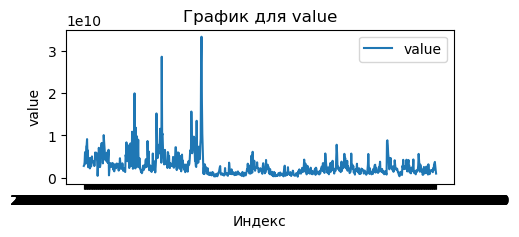


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-13 00:00:00    7.420922e+09
2021-01-14 00:00:00    7.664201e+09
2021-01-15 00:00:00    9.120574e+09
2021-02-25 00:00:00    7.069457e+09
2021-03-04 00:00:00    6.729134e+09
                           ...     
2022-03-24 00:00:00    6.641641e+09
2023-09-21 00:00:00    7.798863e+09
2024-03-19 00:00:00    8.590868e+09
2024-03-20 00:00:00    8.850535e+09
2024-03-21 00:00:00    7.674606e+09
Name: value, Length: 62, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
SBER
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


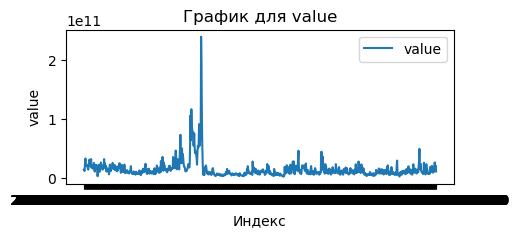


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-11 00:00:00    3.238759e+10
2021-01-25 00:00:00    3.057389e+10
2021-01-29 00:00:00    3.128216e+10
2021-03-17 00:00:00    3.142031e+10
2021-10-05 00:00:00    3.082518e+10
2021-10-06 00:00:00    3.504019e+10
2021-11-12 00:00:00    3.489222e+10
2021-11-22 00:00:00    4.556310e+10
2021-11-23 00:00:00    4.573661e+10
2021-11-30 00:00:00    3.102550e+10
2021-12-06 00:00:00    3.090187e+10
2021-12-07 00:00:00    4.715902e+10
2021-12-08 00:00:00    7.251269e+10
2021-12-09 00:00:00    4.027484e+10
2021-12-13 00:00:00    4.213194e+10
2021-12-14 00:00:00    4.921863e+10
2021-12-16 00:00:00    3.966873e+10
2021-12-17 00:00:00    3.234439e+10
2022-01-13 00:00:00    5.899896e+10
2022-01-14 00:00:00    1.058407e+11
2022-01-17 00:00:00    6.324979e+10
2022-01-18 00:00:00    1.157658e+11
2022-01-19 00:00:00    8.662331e+10
2022-01-20 00:00:00    8.279376e+10
2022-01-21 00:00:00    7.437825e+10
2022-01-24 00:00:00    7.661567e+10
2022-01

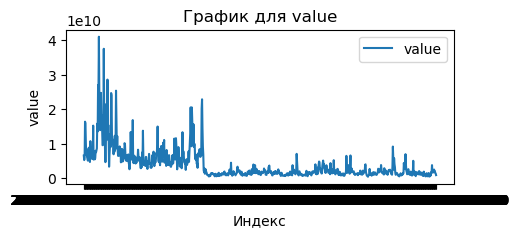


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-08 00:00:00    1.635197e+10
2021-01-11 00:00:00    1.590998e+10
2021-02-05 00:00:00    1.520181e+10
2021-02-19 00:00:00    1.578931e+10
2021-02-20 00:00:00    1.350287e+10
2021-02-22 00:00:00    2.695617e+10
2021-02-24 00:00:00    2.603303e+10
2021-02-25 00:00:00    4.106285e+10
2021-02-26 00:00:00    2.537854e+10
2021-03-01 00:00:00    1.770441e+10
2021-03-02 00:00:00    1.389050e+10
2021-03-03 00:00:00    1.710661e+10
2021-03-04 00:00:00    2.473802e+10
2021-03-05 00:00:00    1.719453e+10
2021-03-09 00:00:00    1.827986e+10
2021-03-10 00:00:00    1.368259e+10
2021-03-15 00:00:00    1.494229e+10
2021-03-16 00:00:00    3.755939e+10
2021-03-17 00:00:00    1.829633e+10
2021-03-18 00:00:00    1.451043e+10
2021-03-24 00:00:00    2.148997e+10
2021-03-26 00:00:00    1.304882e+10
2021-03-29 00:00:00    2.859621e+10
2021-03-30 00:00:00    1.231133e+10
2021-03-31 00:00:00    1.537509e+10
2021-04-01 00:00:00    1.161170e+10
2021-04

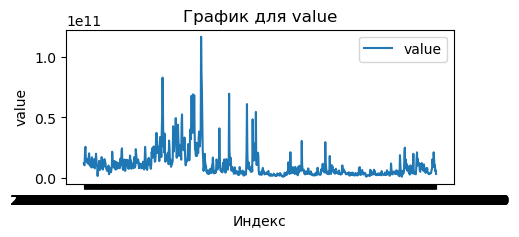


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-09-14 00:00:00    3.284031e+10
2021-09-15 00:00:00    3.721551e+10
2021-09-16 00:00:00    3.227070e+10
2021-09-27 00:00:00    2.845021e+10
2021-09-28 00:00:00    3.374753e+10
2021-10-04 00:00:00    3.791401e+10
2021-10-05 00:00:00    5.160898e+10
2021-10-06 00:00:00    8.309910e+10
2021-10-07 00:00:00    5.926289e+10
2021-10-11 00:00:00    2.886093e+10
2021-10-13 00:00:00    3.665900e+10
2021-10-28 00:00:00    3.081848e+10
2021-11-12 00:00:00    4.271630e+10
2021-11-18 00:00:00    3.599919e+10
2021-11-19 00:00:00    3.262012e+10
2021-11-22 00:00:00    4.923469e+10
2021-11-23 00:00:00    4.942315e+10
2021-11-24 00:00:00    3.166901e+10
2021-11-26 00:00:00    3.410576e+10
2021-11-29 00:00:00    3.371426e+10
2021-11-30 00:00:00    4.395366e+10
2021-12-01 00:00:00    3.210540e+10
2021-12-13 00:00:00    4.502762e+10
2021-12-14 00:00:00    5.255090e+10
2021-12-16 00:00:00    3.147202e+10
2021-12-22 00:00:00    3.335743e+10
2022-01

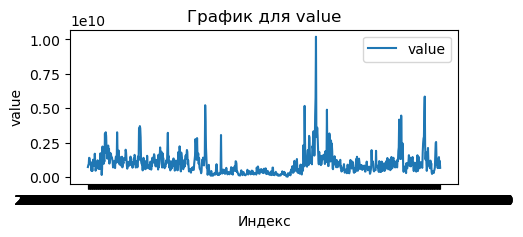


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-03-04 00:00:00    3.177595e+09
2021-03-09 00:00:00    3.267978e+09
2021-03-10 00:00:00    2.996171e+09
2021-04-16 00:00:00    3.264491e+09
2021-07-02 00:00:00    3.567295e+09
2021-07-06 00:00:00    3.712563e+09
2021-07-07 00:00:00    3.562507e+09
2021-07-08 00:00:00    2.869798e+09
2021-10-11 00:00:00    3.227381e+09
2022-01-18 00:00:00    2.771680e+09
2022-01-19 00:00:00    2.482400e+09
2022-01-24 00:00:00    2.845136e+09
2022-02-21 00:00:00    5.228096e+09
2022-02-22 00:00:00    4.023309e+09
2022-05-18 00:00:00    3.069122e+09
2023-05-18 00:00:00    5.179001e+09
2023-05-19 00:00:00    2.666134e+09
2023-06-02 00:00:00    3.005400e+09
2023-06-05 00:00:00    2.878146e+09
2023-06-19 00:00:00    2.712636e+09
2023-06-20 00:00:00    3.341246e+09
2023-06-26 00:00:00    4.513809e+09
2023-06-27 00:00:00    5.766086e+09
2023-06-28 00:00:00    1.019599e+10
2023-06-29 00:00:00    2.916514e+09
2023-06-30 00:00:00    2.953622e+09
2023-07

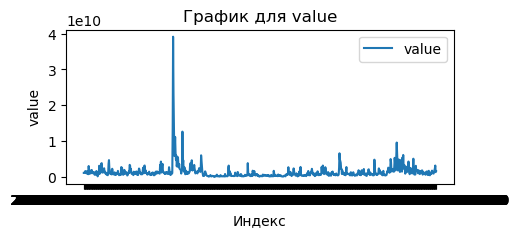


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-21 00:00:00    3.045402e+09
2021-02-26 00:00:00    3.123961e+09
2021-03-05 00:00:00    3.708854e+09
2021-03-09 00:00:00    3.858465e+09
2021-04-01 00:00:00    3.702005e+09
                           ...     
2024-05-20 00:00:00    3.279520e+09
2024-06-03 00:00:00    4.301858e+09
2024-06-20 00:00:00    5.090789e+09
2024-06-28 00:00:00    3.110014e+09
2024-09-04 00:00:00    3.181217e+09
Name: value, Length: 63, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
SNGSp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


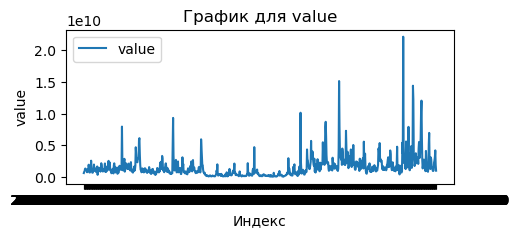


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-05-19 00:00:00    7.952507e+09
2021-07-06 00:00:00    4.694851e+09
2021-07-16 00:00:00    5.827368e+09
2021-07-19 00:00:00    6.128998e+09
2021-11-11 00:00:00    4.756139e+09
2021-11-12 00:00:00    9.320477e+09
2022-02-21 00:00:00    5.946717e+09
2022-02-22 00:00:00    4.571710e+09
2022-09-26 00:00:00    4.714603e+09
2023-05-18 00:00:00    1.013614e+10
2023-06-09 00:00:00    4.348475e+09
2023-06-26 00:00:00    5.696534e+09
2023-06-29 00:00:00    4.043409e+09
2023-06-30 00:00:00    3.958985e+09
2023-08-04 00:00:00    5.477359e+09
2023-08-14 00:00:00    7.890221e+09
2023-08-15 00:00:00    8.707655e+09
2023-08-16 00:00:00    6.418468e+09
2023-09-28 00:00:00    4.478697e+09
2023-09-29 00:00:00    1.512728e+10
2023-10-02 00:00:00    7.958742e+09
2023-10-03 00:00:00    4.405211e+09
2023-10-09 00:00:00    4.211362e+09
2023-10-11 00:00:00    4.493756e+09
2023-10-24 00:00:00    7.289439e+09
2023-10-25 00:00:00    4.759414e+09
2023-10

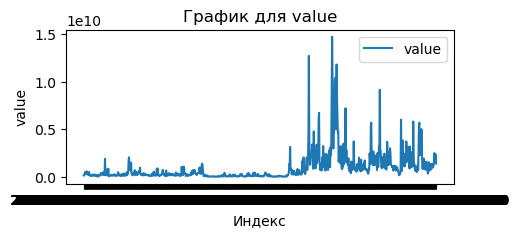


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2023-04-06 00:00:00    3.146002e+09
2023-06-13 00:00:00    4.377257e+09
2023-06-14 00:00:00    1.269662e+10
2023-06-15 00:00:00    3.742444e+09
2023-06-26 00:00:00    3.392274e+09
                           ...     
2024-07-11 00:00:00    5.680479e+09
2024-07-12 00:00:00    2.806181e+09
2024-07-16 00:00:00    4.718586e+09
2024-07-18 00:00:00    5.008621e+09
2024-07-19 00:00:00    2.940894e+09
Name: value, Length: 61, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
SIBN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


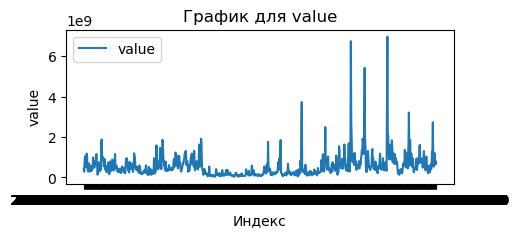


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-03-05 00:00:00    1.718265e+09
2021-03-09 00:00:00    1.884694e+09
2021-09-15 00:00:00    1.591365e+09
2021-09-28 00:00:00    1.466794e+09
2021-10-06 00:00:00    1.865519e+09
2021-10-07 00:00:00    1.663296e+09
2022-02-14 00:00:00    1.632505e+09
2022-02-21 00:00:00    1.917750e+09
2022-02-22 00:00:00    1.607649e+09
2022-11-16 00:00:00    1.761507e+09
2022-12-29 00:00:00    1.855106e+09
2023-05-22 00:00:00    2.679848e+09
2023-05-23 00:00:00    3.730866e+09
2023-08-14 00:00:00    2.489924e+09
2023-09-29 00:00:00    1.548719e+09
2023-10-18 00:00:00    1.635067e+09
2023-11-01 00:00:00    1.564364e+09
2023-11-02 00:00:00    1.695411e+09
2023-11-08 00:00:00    1.596347e+09
2023-11-09 00:00:00    6.749745e+09
2023-11-10 00:00:00    2.801813e+09
2023-11-13 00:00:00    1.786663e+09
2023-12-20 00:00:00    1.915428e+09
2023-12-21 00:00:00    1.758264e+09
2023-12-25 00:00:00    1.502895e+09
2023-12-26 00:00:00    3.767667e+09
2023-12

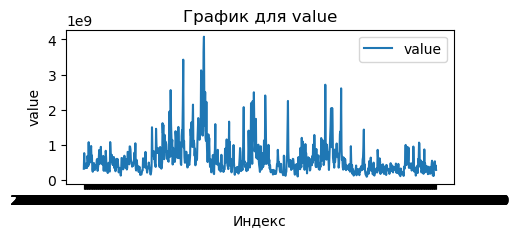


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-08-31 00:00:00    1.497973e+09
2021-09-14 00:00:00    1.454707e+09
2021-10-06 00:00:00    1.613975e+09
2021-10-07 00:00:00    1.332585e+09
2021-10-08 00:00:00    1.565587e+09
                           ...     
2023-09-07 00:00:00    1.524185e+09
2023-10-03 00:00:00    1.304042e+09
2023-10-04 00:00:00    1.376591e+09
2023-10-06 00:00:00    2.606638e+09
2023-12-25 00:00:00    1.431821e+09
Name: value, Length: 62, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
RTKM
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


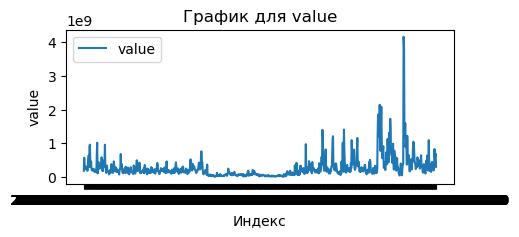


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-21 00:00:00    6.434405e+08
2021-01-25 00:00:00    9.087994e+08
2021-01-26 00:00:00    9.601171e+08
2021-02-18 00:00:00    6.716963e+08
2021-02-19 00:00:00    1.018632e+09
                           ...     
2024-08-07 00:00:00    6.353767e+08
2024-08-13 00:00:00    1.092831e+09
2024-09-02 00:00:00    8.308898e+08
2024-09-04 00:00:00    6.411385e+08
2024-09-05 00:00:00    6.950335e+08
Name: value, Length: 73, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
RTKMp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


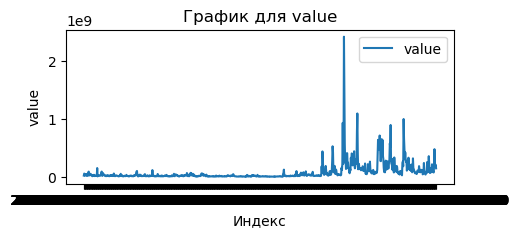


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2023-08-01 00:00:00    180240700.0
2023-08-03 00:00:00    437063922.0
2023-08-04 00:00:00    301645177.5
2023-08-15 00:00:00    186795424.5
2023-09-06 00:00:00    267508902.5
                          ...     
2024-08-30 00:00:00    183017283.0
2024-09-02 00:00:00    475805735.5
2024-09-03 00:00:00    203322779.0
2024-09-04 00:00:00    179640752.5
2024-09-05 00:00:00    208803635.5
Name: value, Length: 103, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
TTLK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


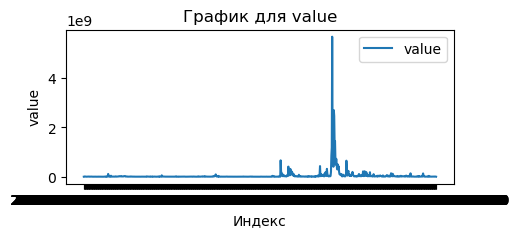


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-03-31 00:00:00    114426490.0
2021-10-04 00:00:00     56982590.5
2022-05-16 00:00:00     49260093.0
2022-05-17 00:00:00     94777590.5
2022-12-29 00:00:00    664104430.5
                          ...     
2024-04-08 00:00:00    120595668.5
2024-04-09 00:00:00     91596562.0
2024-06-10 00:00:00    137117666.0
2024-07-23 00:00:00     70519946.5
2024-07-24 00:00:00    134599156.0
Name: value, Length: 109, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
MOEX
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


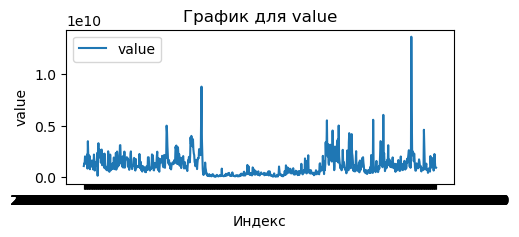


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-19 00:00:00    3.500147e+09
2021-02-24 00:00:00    3.306691e+09
2021-05-12 00:00:00    3.101479e+09
2021-05-13 00:00:00    3.120212e+09
2021-10-20 00:00:00    5.005631e+09
2021-10-21 00:00:00    4.424981e+09
2022-01-14 00:00:00    3.875737e+09
2022-01-17 00:00:00    3.229630e+09
2022-01-18 00:00:00    4.014537e+09
2022-01-19 00:00:00    3.715277e+09
2022-01-20 00:00:00    3.138837e+09
2022-01-24 00:00:00    3.689971e+09
2022-02-21 00:00:00    5.766373e+09
2022-02-22 00:00:00    8.782906e+09
2022-02-24 00:00:00    3.712744e+09
2023-08-15 00:00:00    3.402688e+09
2023-08-18 00:00:00    5.516168e+09
2023-08-23 00:00:00    3.207972e+09
2023-08-30 00:00:00    3.162074e+09
2023-09-07 00:00:00    4.534581e+09
2023-09-22 00:00:00    3.505698e+09
2023-09-26 00:00:00    3.694257e+09
2023-09-28 00:00:00    5.018383e+09
2023-11-02 00:00:00    3.380491e+09
2023-11-03 00:00:00    4.280677e+09
2023-11-13 00:00:00    4.188347e+09
2024-01

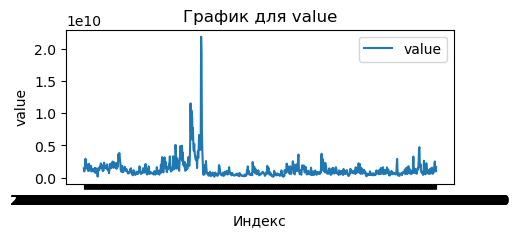


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-01-11 00:00:00    2.937864e+09
2021-05-06 00:00:00    3.648269e+09
2021-05-07 00:00:00    2.997526e+09
2021-05-10 00:00:00    3.827446e+09
2021-05-11 00:00:00    3.790028e+09
                           ...     
2023-08-04 00:00:00    2.874512e+09
2024-04-23 00:00:00    2.917388e+09
2024-06-20 00:00:00    3.279022e+09
2024-07-10 00:00:00    4.452671e+09
2024-07-11 00:00:00    4.728982e+09
Name: value, Length: 62, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
FESH
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


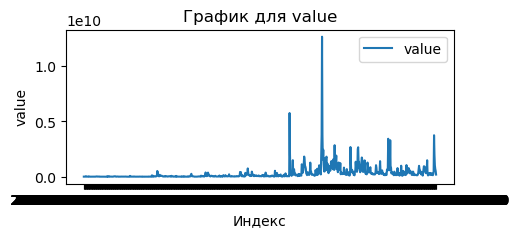


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2023-04-07 00:00:00    5.762063e+09
2023-04-10 00:00:00    2.015544e+09
2023-04-19 00:00:00    1.496763e+09
2023-05-23 00:00:00    1.128553e+09
2023-05-24 00:00:00    1.021111e+09
                           ...     
2024-07-30 00:00:00    9.013335e+08
2024-08-07 00:00:00    1.489826e+09
2024-08-30 00:00:00    3.753264e+09
2024-09-02 00:00:00    1.989157e+09
2024-09-03 00:00:00    1.033552e+09
Name: value, Length: 80, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
FIVE
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


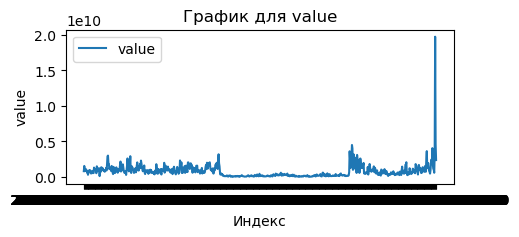


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-03-18 00:00:00    2.891750e+09
2021-03-19 00:00:00    3.012904e+09
2021-05-19 00:00:00    2.609407e+09
2021-05-27 00:00:00    2.926020e+09
2022-02-21 00:00:00    2.354242e+09
2022-02-22 00:00:00    3.195299e+09
2023-07-12 00:00:00    3.616605e+09
2023-07-13 00:00:00    2.548782e+09
2023-07-17 00:00:00    2.574304e+09
2023-07-18 00:00:00    2.803224e+09
2023-07-19 00:00:00    4.505669e+09
2023-07-20 00:00:00    4.020762e+09
2023-07-25 00:00:00    3.162961e+09
2023-07-28 00:00:00    2.717458e+09
2023-08-03 00:00:00    3.105401e+09
2023-08-04 00:00:00    2.426037e+09
2023-08-08 00:00:00    2.409715e+09
2023-08-14 00:00:00    2.600608e+09
2024-03-04 00:00:00    2.514557e+09
2024-03-05 00:00:00    3.638340e+09
2024-03-20 00:00:00    2.455365e+09
2024-03-22 00:00:00    4.060410e+09
2024-03-29 00:00:00    3.338317e+09
2024-04-01 00:00:00    1.975530e+10
2024-04-02 00:00:00    4.625170e+09
2024-04-03 00:00:00    2.384557e+09
Name: v

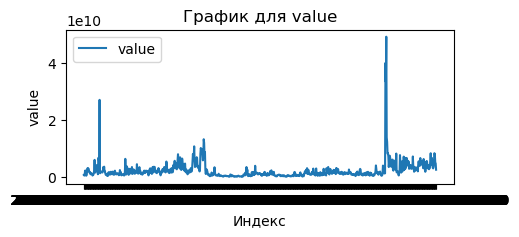


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-02-10 00:00:00    6.012118e+09
2021-02-22 00:00:00    6.717858e+09
2021-02-24 00:00:00    6.547829e+09
2021-02-26 00:00:00    2.698543e+10
2021-05-27 00:00:00    6.368874e+09
                           ...     
2024-08-20 00:00:00    8.330743e+09
2024-08-23 00:00:00    6.677595e+09
2024-08-30 00:00:00    5.589895e+09
2024-09-02 00:00:00    8.355024e+09
2024-09-03 00:00:00    7.893759e+09
Name: value, Length: 67, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
FIXP
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


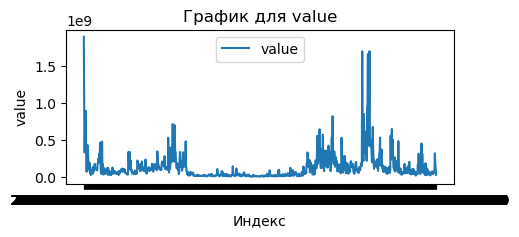


Анализ выбросов:
Найдены выбросы в колонке: value
begin
2021-03-10 00:00:00    1.899511e+09
2021-03-11 00:00:00    8.979147e+08
2021-03-15 00:00:00    6.764415e+08
2021-03-16 00:00:00    4.284923e+08
2021-03-17 00:00:00    8.950995e+08
2021-03-23 00:00:00    4.325169e+08
2021-03-24 00:00:00    3.758615e+08
2021-05-06 00:00:00    4.654340e+08
2021-05-13 00:00:00    4.788869e+08
2021-12-29 00:00:00    5.306458e+08
2022-01-10 00:00:00    3.979424e+08
2022-01-11 00:00:00    3.726452e+08
2022-01-14 00:00:00    4.480929e+08
2022-01-17 00:00:00    7.161055e+08
2022-01-18 00:00:00    3.988703e+08
2022-01-19 00:00:00    3.780887e+08
2022-01-24 00:00:00    7.009170e+08
2022-04-01 00:00:00    4.824380e+08
2023-07-17 00:00:00    5.562442e+08
2023-07-20 00:00:00    3.988781e+08
2023-07-24 00:00:00    5.416167e+08
2023-07-25 00:00:00    6.461987e+08
2023-07-31 00:00:00    3.747823e+08
2023-08-04 00:00:00    5.719227e+08
2023-08-15 00:00:00    3.556043e+08
2023-08-24 00:00:00    4.232213e+08
2023-09

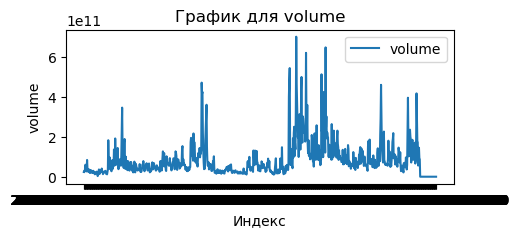


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-05-18 00:00:00    218991330000
2021-05-19 00:00:00    347106250000
2022-01-24 00:00:00    217314170000
2022-02-21 00:00:00    472628730000
2022-02-22 00:00:00    417837380000
                           ...     
2024-05-31 00:00:00    234379330000
2024-06-03 00:00:00    236266840000
2024-06-04 00:00:00    200770900000
2024-06-26 00:00:00    418582100000
2024-06-27 00:00:00    286744260000
Name: volume, Length: 69, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
LEAS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


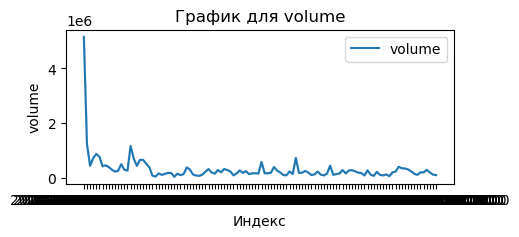


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2024-03-29 00:00:00    5161193
2024-04-01 00:00:00    1235147
2024-04-03 00:00:00     721561
2024-04-04 00:00:00     876915
2024-04-05 00:00:00     774458
2024-04-19 00:00:00    1164353
2024-04-22 00:00:00     708410
2024-04-24 00:00:00     657652
2024-04-25 00:00:00     659898
2024-06-20 00:00:00     582309
2024-07-05 00:00:00     733028
2024-03-29 00:00:00    5161193
2024-04-01 00:00:00    1235147
2024-04-03 00:00:00     721561
2024-04-04 00:00:00     876915
2024-04-05 00:00:00     774458
2024-04-19 00:00:00    1164353
2024-04-22 00:00:00     708410
2024-04-24 00:00:00     657652
2024-04-25 00:00:00     659898
2024-06-20 00:00:00     582309
2024-07-05 00:00:00     733028
Name: volume, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
IRAO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


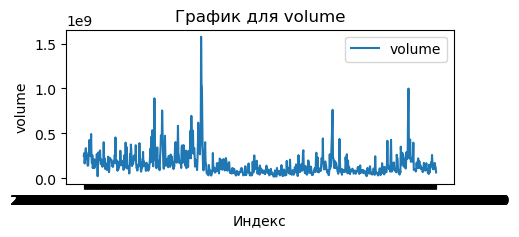


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-25 00:00:00     427751000
2021-01-29 00:00:00     493481000
2021-03-16 00:00:00     402355600
2021-04-26 00:00:00     455746800
2021-06-01 00:00:00     398176300
2021-06-18 00:00:00     376454600
2021-07-06 00:00:00     369633200
2021-07-19 00:00:00     391725100
2021-08-27 00:00:00     461880300
2021-09-01 00:00:00     535890300
2021-09-08 00:00:00     890325900
2021-09-30 00:00:00     478381800
2021-10-01 00:00:00     423975000
2021-10-04 00:00:00     425262600
2021-10-05 00:00:00     755640600
2021-10-06 00:00:00     529685700
2021-10-14 00:00:00     474838600
2021-11-19 00:00:00     375641000
2021-11-22 00:00:00     403667700
2021-11-26 00:00:00     382829100
2021-11-30 00:00:00     584800900
2021-12-14 00:00:00     366625100
2021-12-20 00:00:00     369442900
2022-01-14 00:00:00     532939100
2022-01-18 00:00:00     695991800
2022-01-24 00:00:00     530953300
2022-02-10 00:00:00     619587700
2022-02-11 00:00:00     

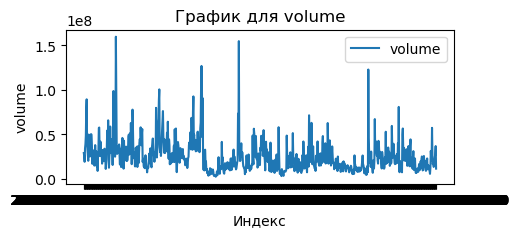


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-13 00:00:00     77334660
2021-01-14 00:00:00     89442600
2021-03-31 00:00:00     65850200
2021-04-19 00:00:00     98767480
2021-04-21 00:00:00     64171260
2021-04-27 00:00:00    159749710
2021-04-28 00:00:00     91104150
2021-06-18 00:00:00     62857800
2021-06-24 00:00:00     77863010
2021-09-14 00:00:00     79875780
2021-09-21 00:00:00     61956160
2021-09-22 00:00:00     67656740
2021-09-23 00:00:00     89077150
2021-09-24 00:00:00    100598300
2021-10-06 00:00:00     68032270
2021-10-07 00:00:00     76243060
2021-10-25 00:00:00     64273370
2022-01-18 00:00:00     68610630
2022-01-19 00:00:00     66452020
2022-01-24 00:00:00     75845880
2022-01-25 00:00:00     92715190
2022-02-18 00:00:00     63261560
2022-02-21 00:00:00    105064220
2022-02-22 00:00:00    126913000
2022-02-24 00:00:00    104651610
2022-03-24 00:00:00     90675890
2022-08-01 00:00:00     73364610
2022-08-03 00:00:00    154782470
2023-06-19 00:00:0

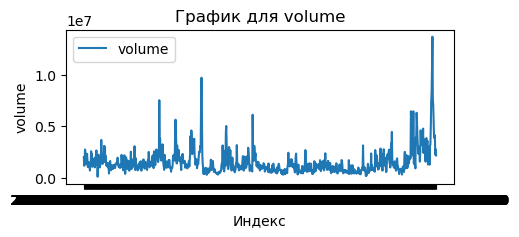


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-03-05 00:00:00     3674586
2021-09-24 00:00:00     7540374
2021-09-27 00:00:00     3374827
2021-09-28 00:00:00     3794077
2021-10-06 00:00:00     3246337
2021-11-19 00:00:00     4360396
2021-11-22 00:00:00     5645710
2021-11-23 00:00:00     4480839
2022-01-14 00:00:00     4064903
2022-01-18 00:00:00     4594963
2022-01-19 00:00:00     3737694
2022-01-24 00:00:00     3755398
2022-01-27 00:00:00     3786312
2022-02-21 00:00:00     7506232
2022-02-22 00:00:00     9726127
2022-02-24 00:00:00     5532902
2022-06-20 00:00:00     4383355
2022-06-21 00:00:00     5033194
2022-07-27 00:00:00     3172595
2022-09-20 00:00:00     6126838
2024-04-02 00:00:00     3327392
2024-04-04 00:00:00     4453362
2024-06-11 00:00:00     6461694
2024-06-13 00:00:00     4691335
2024-06-17 00:00:00     3320950
2024-06-20 00:00:00     6464328
2024-06-28 00:00:00     3928747
2024-07-01 00:00:00     3445401
2024-07-02 00:00:00     6315658
2024-07-03 00:

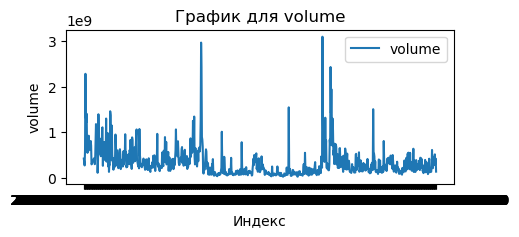


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-11 00:00:00    2284089000
2021-01-12 00:00:00    1338582000
2021-01-13 00:00:00    1214410000
2021-01-14 00:00:00    1404076000
2021-01-21 00:00:00     921511000
2021-02-16 00:00:00    1177378000
2021-02-17 00:00:00     989955000
2021-02-24 00:00:00    1393651000
2021-03-02 00:00:00     856989000
2021-03-10 00:00:00    1089458000
2021-03-11 00:00:00    1106349000
2021-03-24 00:00:00    1299509000
2021-03-30 00:00:00     978306000
2021-04-07 00:00:00    1459597000
2021-04-08 00:00:00    1372186000
2021-04-13 00:00:00    1145767000
2021-04-26 00:00:00     947456000
2021-05-31 00:00:00     954086000
2021-06-23 00:00:00     884524000
2021-07-07 00:00:00     915295000
2021-07-08 00:00:00    1059374000
2021-07-19 00:00:00    1069201000
2021-09-17 00:00:00     962383000
2021-10-14 00:00:00     891302000
2021-11-23 00:00:00    1060189000
2022-01-14 00:00:00     863684000
2022-01-24 00:00:00    1248746000
2022-01-27 00:00:00    1

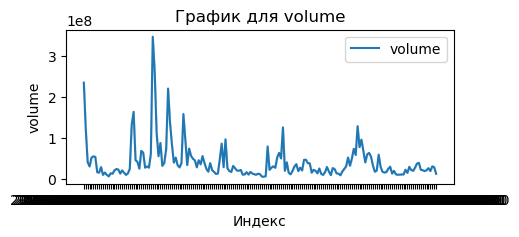


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2023-12-15 00:00:00    235374000
2023-12-18 00:00:00    122471200
2024-01-23 00:00:00    132442400
2024-01-24 00:00:00    164047600
2024-02-07 00:00:00    347733900
2024-02-08 00:00:00    263518900
2024-02-09 00:00:00    113769800
2024-02-19 00:00:00    221001600
2024-02-20 00:00:00    138571800
2024-03-01 00:00:00    158723800
2024-03-04 00:00:00     96795200
2024-04-03 00:00:00     96927200
2024-05-16 00:00:00    126112700
2024-07-11 00:00:00    129039600
2024-07-15 00:00:00     96074400
2023-12-15 00:00:00    235374000
2023-12-18 00:00:00    122471200
2024-01-23 00:00:00    132442400
2024-01-24 00:00:00    164047600
2024-02-07 00:00:00    347733900
2024-02-08 00:00:00    263518900
2024-02-09 00:00:00    113769800
2024-02-19 00:00:00    221001600
2024-02-20 00:00:00    138571800
2024-03-01 00:00:00    158723800
2024-03-04 00:00:00     96795200
2024-04-03 00:00:00     96927200
2024-05-16 00:00:00    126112700
2024-07-11 00:00:0

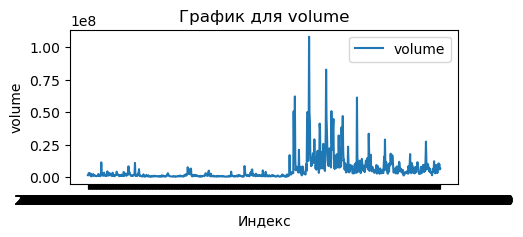


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2023-01-17 00:00:00    16794240
2023-04-07 00:00:00    50602140
2023-04-10 00:00:00    23458010
2023-04-12 00:00:00    62077110
2023-04-26 00:00:00    20928760
                         ...   
2024-03-18 00:00:00    17948080
2024-03-22 00:00:00    16755350
2024-03-25 00:00:00    14274620
2024-05-24 00:00:00    17633220
2024-07-19 00:00:00    27214710
Name: volume, Length: 68, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
UPRO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


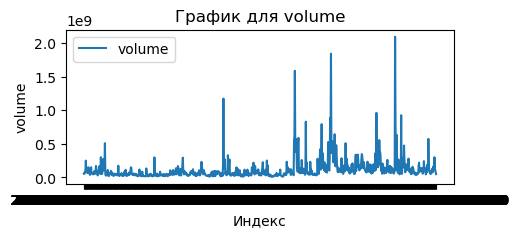


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-12 00:00:00    249519000
2021-03-04 00:00:00    299945000
2021-03-15 00:00:00    275161000
2021-03-19 00:00:00    509201000
2021-09-08 00:00:00    297039000
                         ...    
2024-05-17 00:00:00    474085000
2024-05-20 00:00:00    261062000
2024-06-03 00:00:00    280083000
2024-08-12 00:00:00    573125000
2024-09-02 00:00:00    300110000
Name: volume, Length: 75, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
ALRS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


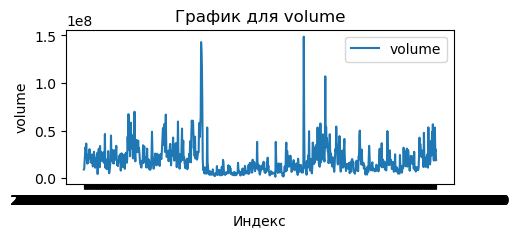


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-03-19 00:00:00     46431980
2021-06-10 00:00:00     67298740
2021-06-17 00:00:00     53140240
2021-06-18 00:00:00     58374630
2021-07-01 00:00:00     69864230
2021-08-31 00:00:00     48750460
2021-10-07 00:00:00     52702410
2021-10-11 00:00:00     51640750
2021-10-13 00:00:00     57124650
2021-10-18 00:00:00     66795880
2021-11-30 00:00:00     59501350
2021-12-14 00:00:00     52164260
2022-01-18 00:00:00     47416270
2022-01-19 00:00:00     60513140
2022-01-20 00:00:00     56030330
2022-01-21 00:00:00     53475580
2022-01-24 00:00:00     60362050
2022-01-25 00:00:00     48223540
2022-02-14 00:00:00     57936330
2022-02-17 00:00:00     58025650
2022-02-18 00:00:00     64321790
2022-02-21 00:00:00    143026420
2022-02-22 00:00:00    132849650
2022-02-24 00:00:00    116515070
2022-02-25 00:00:00     78525480
2022-04-08 00:00:00     53215250
2023-05-30 00:00:00    148679510
2023-05-31 00:00:00     57055900
2023-06-19 00:00:0

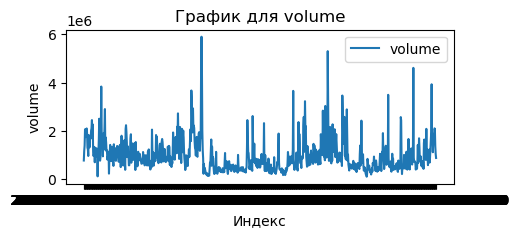


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-02-02 00:00:00    2451039
2021-02-26 00:00:00    2508179
2021-03-05 00:00:00    3839237
2021-03-19 00:00:00    2907248
2021-11-30 00:00:00    2729250
2022-01-18 00:00:00    3676435
2022-01-19 00:00:00    3237227
2022-01-24 00:00:00    2935738
2022-02-21 00:00:00    4538212
2022-02-22 00:00:00    5901625
2022-02-24 00:00:00    4692673
2022-09-01 00:00:00    2450494
2022-09-20 00:00:00    2618662
2022-10-28 00:00:00    2324509
2023-04-20 00:00:00    3660601
2023-05-11 00:00:00    2368559
2023-05-30 00:00:00    2582957
2023-06-02 00:00:00    3232253
2023-08-04 00:00:00    2841306
2023-08-14 00:00:00    3036111
2023-08-22 00:00:00    5303696
2023-08-23 00:00:00    2949873
2023-10-11 00:00:00    3467588
2023-10-12 00:00:00    2719991
2023-10-18 00:00:00    2585069
2023-10-26 00:00:00    2894431
2023-12-15 00:00:00    2428092
2024-03-22 00:00:00    3496776
2024-05-06 00:00:00    2575025
2024-05-07 00:00:00    2435049
2024-06-20 0

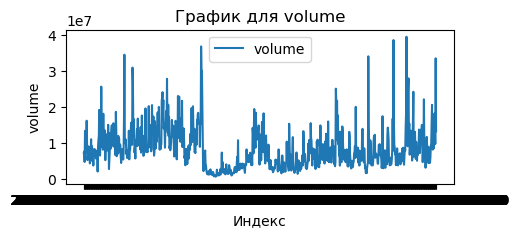


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-03-05 00:00:00    25693810
2021-05-27 00:00:00    34589490
2021-06-24 00:00:00    30995690
2021-06-25 00:00:00    26534940
2021-10-04 00:00:00    21865890
2021-10-05 00:00:00    22612270
2021-10-06 00:00:00    24145220
2021-10-08 00:00:00    21948460
2021-10-21 00:00:00    27852820
2021-10-26 00:00:00    20654710
2021-11-30 00:00:00    23083410
2021-12-03 00:00:00    22902330
2021-12-14 00:00:00    21746060
2022-02-21 00:00:00    36896340
2022-02-22 00:00:00    30427210
2022-02-24 00:00:00    30188520
2022-02-25 00:00:00    22097810
2023-09-19 00:00:00    25128170
2023-09-20 00:00:00    21329930
2023-09-22 00:00:00    21761310
2024-01-11 00:00:00    34133390
2024-04-10 00:00:00    38668700
2024-05-27 00:00:00    39592770
2024-05-31 00:00:00    24281760
2024-06-03 00:00:00    28006790
2024-06-20 00:00:00    24262890
2024-07-26 00:00:00    22160260
2024-09-05 00:00:00    33575460
Name: volume, dtype: int64

Выбросы были найде

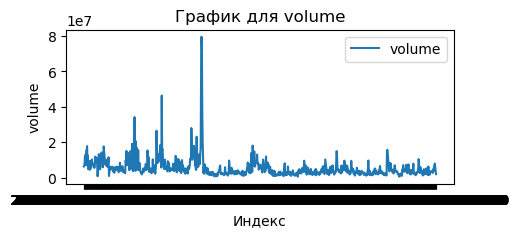


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-08 00:00:00    12774820
2021-01-13 00:00:00    15295510
2021-01-14 00:00:00    15398010
2021-01-15 00:00:00    17894440
2021-02-25 00:00:00    13384710
2021-03-05 00:00:00    13678500
2021-03-09 00:00:00    14355410
2021-03-16 00:00:00    17701530
2021-03-17 00:00:00    15266980
2021-06-03 00:00:00    15173770
2021-06-10 00:00:00    13982910
2021-06-17 00:00:00    15043640
2021-06-23 00:00:00    19205750
2021-06-24 00:00:00    15285040
2021-06-30 00:00:00    14690150
2021-07-01 00:00:00    34228650
2021-07-02 00:00:00    13340700
2021-07-06 00:00:00    20639390
2021-07-07 00:00:00    14465650
2021-07-08 00:00:00    13955330
2021-07-09 00:00:00    16854600
2021-07-14 00:00:00    15586600
2021-08-16 00:00:00    15439330
2021-09-15 00:00:00    26552756
2021-09-16 00:00:00    17645321
2021-09-22 00:00:00    13356364
2021-09-23 00:00:00    12921389
2021-09-24 00:00:00    12949695
2021-09-27 00:00:00    12981662
2021-09-28 00:

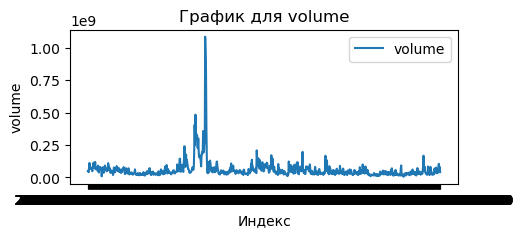


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-29 00:00:00     120123710
2021-11-22 00:00:00     144394030
2021-11-23 00:00:00     144887010
2021-12-07 00:00:00     154172870
2021-12-08 00:00:00     241043180
2021-12-09 00:00:00     133933650
2021-12-13 00:00:00     146312930
2021-12-14 00:00:00     176483200
2021-12-16 00:00:00     134813120
2022-01-13 00:00:00     211556190
2022-01-14 00:00:00     406253690
2022-01-17 00:00:00     248689250
2022-01-18 00:00:00     484056480
2022-01-19 00:00:00     360958990
2022-01-20 00:00:00     329113650
2022-01-21 00:00:00     295690670
2022-01-24 00:00:00     325829650
2022-01-25 00:00:00     232596970
2022-01-26 00:00:00     224840650
2022-01-27 00:00:00     301306340
2022-01-28 00:00:00     204180270
2022-01-31 00:00:00     156175080
2022-02-01 00:00:00     170396140
2022-02-02 00:00:00     170215080
2022-02-03 00:00:00     151173100
2022-02-04 00:00:00     127035170
2022-02-08 00:00:00     161506220
2022-02-09 00:00:00     

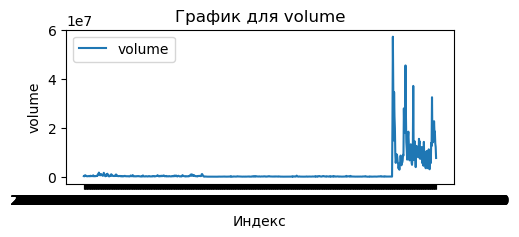


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-02-22 00:00:00     1026319
2021-02-24 00:00:00     1030385
2021-02-25 00:00:00     1718063
2021-02-26 00:00:00     1087035
2021-03-01 00:00:00      740109
                         ...   
2024-09-02 00:00:00    18182150
2024-09-03 00:00:00    18487270
2024-09-04 00:00:00    13677770
2024-09-05 00:00:00    12165030
2024-09-06 00:00:00     7663410
Name: volume, Length: 132, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
GAZP
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


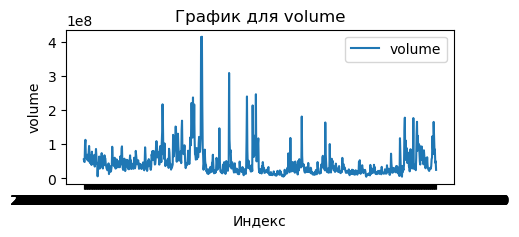


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-11 00:00:00    112708870
2021-09-15 00:00:00    108867890
2021-10-05 00:00:00    134614700
2021-10-06 00:00:00    216502410
2021-10-07 00:00:00    160554040
2021-11-12 00:00:00    127208680
2021-11-22 00:00:00    151496580
2021-11-23 00:00:00    150584250
2021-11-30 00:00:00    130559830
2021-12-13 00:00:00    140582280
2021-12-14 00:00:00    168689260
2022-01-13 00:00:00    118269470
2022-01-14 00:00:00    120568340
2022-01-18 00:00:00    220122140
2022-01-19 00:00:00    220090450
2022-01-20 00:00:00    130272450
2022-01-21 00:00:00    119138170
2022-01-24 00:00:00    236552480
2022-01-25 00:00:00    143186690
2022-01-26 00:00:00    125078000
2022-01-27 00:00:00    216081130
2022-01-28 00:00:00    116239740
2022-02-14 00:00:00    121315290
2022-02-18 00:00:00    125466600
2022-02-21 00:00:00    413310930
2022-02-22 00:00:00    324950590
2022-02-24 00:00:00    414024040
2022-02-25 00:00:00    211877250
2022-05-26 00:00:0

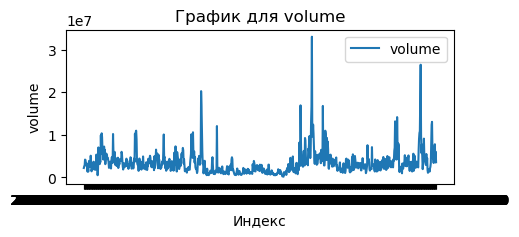


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-03-04 00:00:00     9908030
2021-03-09 00:00:00    10357870
2021-03-10 00:00:00     9477370
2021-04-16 00:00:00    10195300
2021-07-02 00:00:00    10263010
2021-07-06 00:00:00    10636140
2021-07-07 00:00:00    10971920
2021-07-08 00:00:00     8971160
2021-10-11 00:00:00    10082650
2022-01-18 00:00:00    10127660
2022-01-19 00:00:00     8948670
2022-01-24 00:00:00    10598480
2022-02-21 00:00:00    20241630
2022-02-22 00:00:00    16722690
2022-02-24 00:00:00    10842040
2022-05-18 00:00:00    12055920
2023-05-15 00:00:00     8177650
2023-05-18 00:00:00    16911330
2023-05-19 00:00:00     8635080
2023-06-02 00:00:00     9258900
2023-06-05 00:00:00     8725580
2023-06-19 00:00:00     7874750
2023-06-20 00:00:00     9709580
2023-06-26 00:00:00    13082520
2023-06-27 00:00:00    16676840
2023-06-28 00:00:00    32998900
2023-06-29 00:00:00     9590060
2023-06-30 00:00:00     9881760
2023-07-03 00:00:00    12396720
2023-07-04 00:

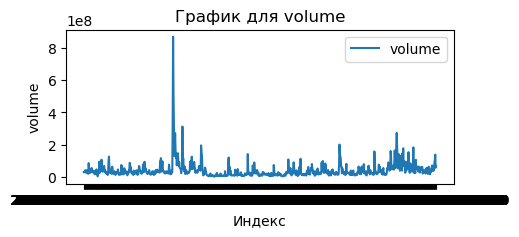


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-02-26 00:00:00     95223100
2021-03-05 00:00:00    107354600
2021-03-09 00:00:00    107220200
2021-04-01 00:00:00    103428100
2021-04-02 00:00:00    127367600
                         ...    
2024-06-20 00:00:00    184239900
2024-06-28 00:00:00    107436700
2024-09-02 00:00:00     92487900
2024-09-03 00:00:00    107887900
2024-09-04 00:00:00    139488500
Name: volume, Length: 65, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
SNGSp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


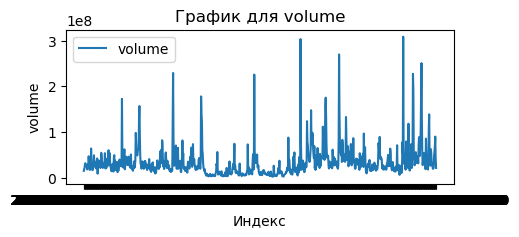


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-05-19 00:00:00    172392300
2021-07-06 00:00:00     98027500
2021-07-07 00:00:00     77160500
2021-07-16 00:00:00    126597000
2021-07-19 00:00:00    156716800
2021-07-20 00:00:00     94000700
2021-10-05 00:00:00     81956700
2021-11-11 00:00:00    121107700
2021-11-12 00:00:00    229014800
2021-11-15 00:00:00     84060100
2021-12-15 00:00:00     81420400
2022-02-21 00:00:00    177891900
2022-02-22 00:00:00    138144900
2022-02-24 00:00:00    123519300
2022-09-26 00:00:00    225442500
2023-04-04 00:00:00     87760000
2023-05-18 00:00:00    303118700
2023-06-09 00:00:00    123547300
2023-06-13 00:00:00     79121600
2023-06-26 00:00:00    147668100
2023-06-28 00:00:00     76508500
2023-06-29 00:00:00     98509200
2023-06-30 00:00:00     95245200
2023-08-04 00:00:00    111539200
2023-08-14 00:00:00    156099500
2023-08-15 00:00:00    174996800
2023-08-16 00:00:00    133862700
2023-09-28 00:00:00     86147300
2023-09-29 00:00:0

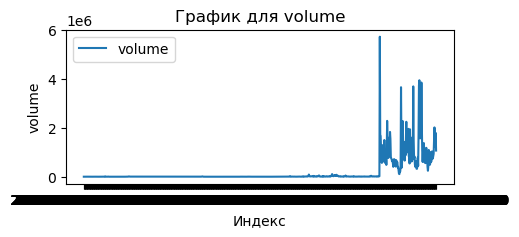


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2023-06-13 00:00:00      32418
2023-06-14 00:00:00      89609
2023-06-30 00:00:00      33575
2023-07-18 00:00:00      43829
2023-07-19 00:00:00      52816
                        ...   
2024-09-02 00:00:00    2016186
2024-09-03 00:00:00    1666853
2024-09-04 00:00:00    1225136
2024-09-05 00:00:00    1791919
2024-09-06 00:00:00    1070297
Name: volume, Length: 163, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
SIBN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


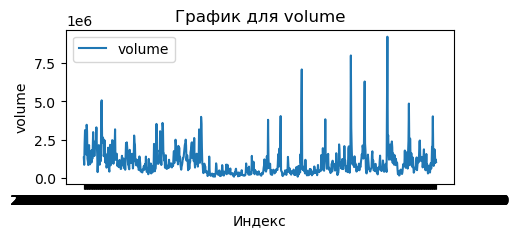


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-08 00:00:00    3128710
2021-01-14 00:00:00    3478280
2021-01-15 00:00:00    3069790
2021-02-05 00:00:00    3000300
2021-02-17 00:00:00    3310600
2021-03-05 00:00:00    4842300
2021-03-09 00:00:00    5068560
2021-03-10 00:00:00    2745560
2021-03-12 00:00:00    2650140
2021-03-15 00:00:00    2563160
2021-04-23 00:00:00    3181690
2021-06-30 00:00:00    2778200
2021-09-15 00:00:00    3534820
2021-09-28 00:00:00    3059410
2021-10-05 00:00:00    2736770
2021-10-06 00:00:00    3598230
2021-10-07 00:00:00    3317960
2022-01-27 00:00:00    2617710
2022-02-14 00:00:00    3178100
2022-02-21 00:00:00    3993380
2022-02-22 00:00:00    3533010
2022-11-16 00:00:00    3801676
2022-12-29 00:00:00    4044220
2023-05-22 00:00:00    4910279
2023-05-23 00:00:00    7079650
2023-08-14 00:00:00    3836117
2023-11-09 00:00:00    7989855
2023-11-10 00:00:00    3278016
2023-12-26 00:00:00    4074149
2023-12-27 00:00:00    6294912
2024-03-19 0

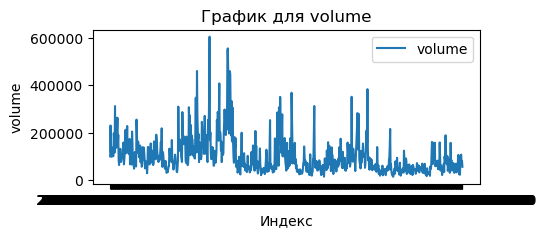


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-21 00:00:00    312289
2021-01-25 00:00:00    262928
2021-01-29 00:00:00    262960
2021-04-07 00:00:00    255019
2021-08-31 00:00:00    309897
2021-09-14 00:00:00    286882
2021-10-06 00:00:00    307454
2021-10-07 00:00:00    242814
2021-10-08 00:00:00    273498
2021-10-29 00:00:00    347542
2021-11-03 00:00:00    460851
2021-11-05 00:00:00    274317
2021-11-22 00:00:00    245252
2021-12-01 00:00:00    270671
2021-12-14 00:00:00    254666
2021-12-15 00:00:00    236132
2021-12-16 00:00:00    368102
2021-12-17 00:00:00    605887
2022-01-14 00:00:00    253300
2022-01-18 00:00:00    286894
2022-01-19 00:00:00    277292
2022-01-21 00:00:00    298261
2022-01-24 00:00:00    408267
2022-02-09 00:00:00    244551
2022-02-10 00:00:00    297740
2022-02-11 00:00:00    253496
2022-02-14 00:00:00    259484
2022-02-18 00:00:00    265418
2022-02-21 00:00:00    548098
2022-02-22 00:00:00    556635
2022-02-24 00:00:00    456905
2022-02-25 0

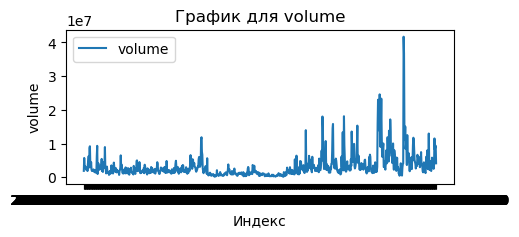


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-25 00:00:00     8710970
2021-01-26 00:00:00     9208830
2021-02-19 00:00:00     9339120
2021-03-19 00:00:00     8974040
2022-02-21 00:00:00    11218820
                         ...   
2024-08-13 00:00:00    12988870
2024-09-02 00:00:00    11529710
2024-09-03 00:00:00     8234820
2024-09-04 00:00:00     9014630
2024-09-05 00:00:00     9393710
Name: volume, Length: 70, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
RTKMp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


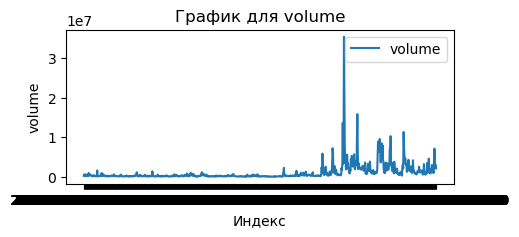


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2023-08-01 00:00:00    2426340
2023-08-03 00:00:00    5868750
2023-08-04 00:00:00    4075750
2023-08-15 00:00:00    2563680
2023-09-06 00:00:00    3704970
                        ...   
2024-08-30 00:00:00    2569180
2024-09-02 00:00:00    7128630
2024-09-03 00:00:00    3104160
2024-09-04 00:00:00    2680150
2024-09-05 00:00:00    3025030
Name: volume, Length: 100, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
TTLK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


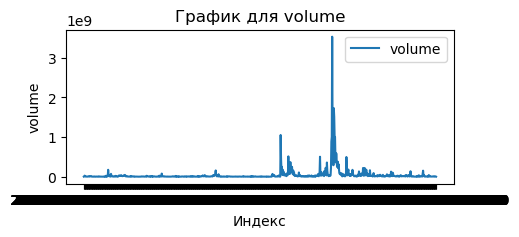


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-03-31 00:00:00    175410000
2021-04-01 00:00:00     56140000
2021-04-09 00:00:00     73590000
2021-10-04 00:00:00     79817000
2022-05-16 00:00:00     74987000
                         ...    
2024-04-08 00:00:00    104508000
2024-04-09 00:00:00     78868000
2024-06-10 00:00:00    138666000
2024-07-23 00:00:00     84213000
2024-07-24 00:00:00    153318000
Name: volume, Length: 109, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
MOEX
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


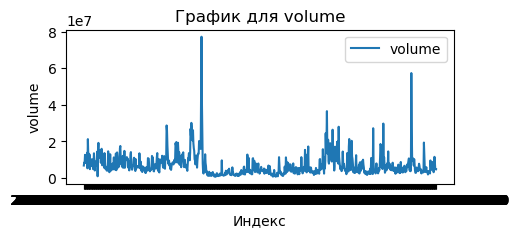


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-01-19 00:00:00    21240210
2021-02-24 00:00:00    19202890
2021-05-13 00:00:00    17496820
2021-10-20 00:00:00    28703800
2021-10-21 00:00:00    25894860
2021-10-22 00:00:00    17708660
2021-11-22 00:00:00    19091030
2021-11-23 00:00:00    17924770
2021-11-24 00:00:00    19663170
2021-11-30 00:00:00    19257960
2022-01-14 00:00:00    26874980
2022-01-17 00:00:00    23172710
2022-01-18 00:00:00    30127050
2022-01-19 00:00:00    27393570
2022-01-20 00:00:00    21942650
2022-01-21 00:00:00    20544990
2022-01-24 00:00:00    26108780
2022-01-25 00:00:00    19066010
2022-02-14 00:00:00    20189690
2022-02-15 00:00:00    17746570
2022-02-16 00:00:00    18255300
2022-02-17 00:00:00    17753570
2022-02-21 00:00:00    46477680
2022-02-22 00:00:00    77162000
2022-02-24 00:00:00    42143160
2022-02-25 00:00:00    24021070
2023-06-15 00:00:00    17231000
2023-08-15 00:00:00    24447650
2023-08-17 00:00:00    20424690
2023-08-18 00:

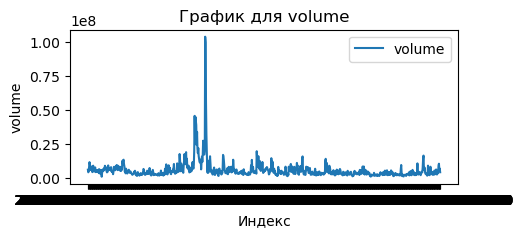


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-05-06 00:00:00    12457660
2021-05-10 00:00:00    12826530
2021-05-11 00:00:00    13270920
2021-11-22 00:00:00    17452180
2021-11-23 00:00:00    13177770
                         ...   
2023-05-11 00:00:00    15682350
2023-07-31 00:00:00    12440490
2023-08-01 00:00:00    13911910
2024-07-10 00:00:00    14057160
2024-07-11 00:00:00    16298390
Name: volume, Length: 61, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
FESH
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


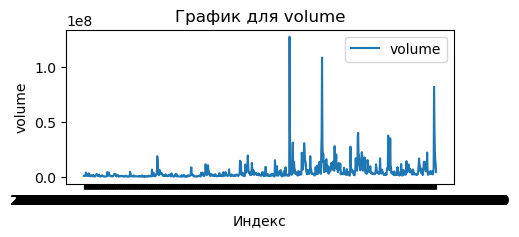


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-09-17 00:00:00    18832300
2021-09-20 00:00:00    15198000
2022-04-06 00:00:00    11469900
2022-08-10 00:00:00    14684900
2022-08-12 00:00:00    13521200
                         ...   
2024-08-30 00:00:00    82108380
2024-09-02 00:00:00    45501300
2024-09-03 00:00:00    23324990
2024-09-04 00:00:00    15454380
2024-09-05 00:00:00    11263160
Name: volume, Length: 84, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
FIVE
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


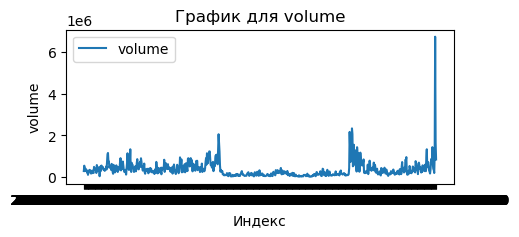


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-03-18 00:00:00    1096406
2021-03-19 00:00:00    1160616
2021-05-19 00:00:00    1143965
2021-05-27 00:00:00    1335911
2021-10-25 00:00:00     948697
2022-01-18 00:00:00    1144595
2022-01-19 00:00:00    1057644
2022-01-21 00:00:00    1090397
2022-01-24 00:00:00    1099174
2022-01-25 00:00:00    1235917
2022-01-26 00:00:00    1229557
2022-02-14 00:00:00    1048031
2022-02-16 00:00:00    1078324
2022-02-21 00:00:00    1406798
2022-02-22 00:00:00    2055014
2022-02-24 00:00:00    1660475
2022-02-25 00:00:00    1215622
2023-07-12 00:00:00    2165620
2023-07-13 00:00:00    1489740
2023-07-17 00:00:00    1430491
2023-07-18 00:00:00    1533595
2023-07-19 00:00:00    2335189
2023-07-20 00:00:00    2063327
2023-07-25 00:00:00    1552165
2023-07-26 00:00:00     968519
2023-07-28 00:00:00    1283917
2023-08-03 00:00:00    1435190
2023-08-04 00:00:00    1127760
2023-08-08 00:00:00    1135537
2023-08-14 00:00:00    1175437
2023-12-29 0

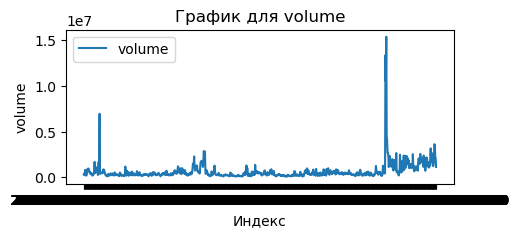


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-02-10 00:00:00    1678973
2021-02-22 00:00:00    1596665
2021-02-24 00:00:00    1692143
2021-02-26 00:00:00    6949597
2022-01-14 00:00:00    1474537
                        ...   
2024-08-30 00:00:00    2286677
2024-09-02 00:00:00    3618862
2024-09-03 00:00:00    3494462
2024-09-04 00:00:00    2213320
2024-09-05 00:00:00    2056548
Name: volume, Length: 87, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
FIXP
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


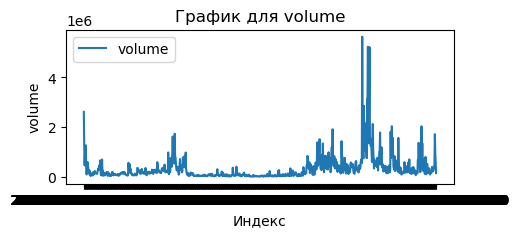


Анализ выбросов:
Найдены выбросы в колонке: volume
begin
2021-03-10 00:00:00    2614386
2021-03-11 00:00:00    1277701
2021-03-15 00:00:00     955647
2021-03-17 00:00:00    1268379
2021-12-29 00:00:00     983483
                        ...   
2024-07-10 00:00:00     919205
2024-07-18 00:00:00    2031012
2024-07-22 00:00:00    1347536
2024-09-03 00:00:00    1717603
2024-09-04 00:00:00     917754
Name: volume, Length: 65, dtype: int64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.


In [147]:
for column in ['open', 'high', 'low', 'value', 'volume']:
    print(column)
    df_kotirovki_analyze_data = df_kotirovki[[column, 'symbol', 'begin']].set_index('begin')
    for symbol in symbol_list:
        print(symbol)
        analyze_data(df_kotirovki_analyze_data.loc[df_kotirovki_analyze_data['symbol'] == symbol])

close
VTBR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


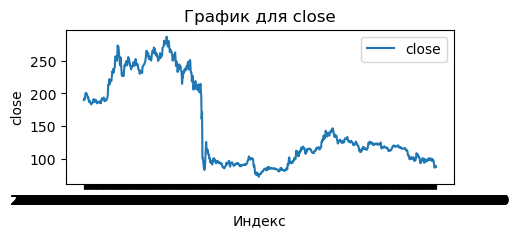


Анализ выбросов:

Выбросы не найдены.
LEAS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


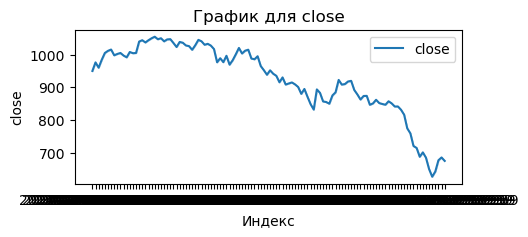


Анализ выбросов:

Выбросы не найдены.
IRAO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


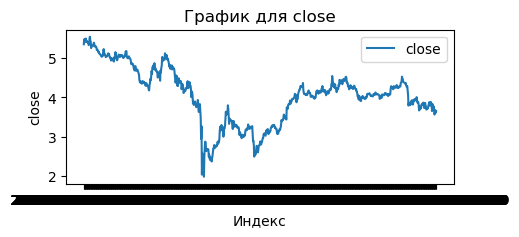


Анализ выбросов:
Найдены выбросы в колонке: close
end
2022-02-24 23:59:59    2.0430
2022-03-24 23:59:59    2.4000
2022-03-25 23:59:59    2.2325
2022-03-28 23:59:59    2.0820
2022-03-29 23:59:59    1.9890
2022-03-30 23:59:59    2.4970
2022-04-14 23:59:59    2.4955
2022-04-18 23:59:59    2.4500
2022-04-19 23:59:59    2.4145
2022-04-20 23:59:59    2.4800
2022-04-21 23:59:59    2.4345
2022-04-22 23:59:59    2.4300
2022-04-25 23:59:59    2.3750
2022-04-26 23:59:59    2.4600
2022-04-27 23:59:59    2.5100
2022-09-26 23:59:59    2.5000
Name: close, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
MAGN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


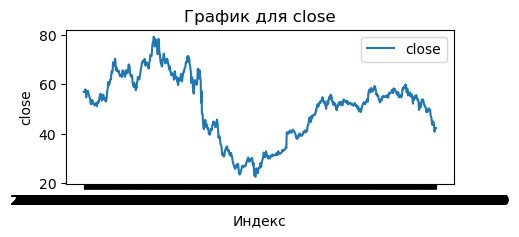


Анализ выбросов:

Выбросы не найдены.
NVTK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


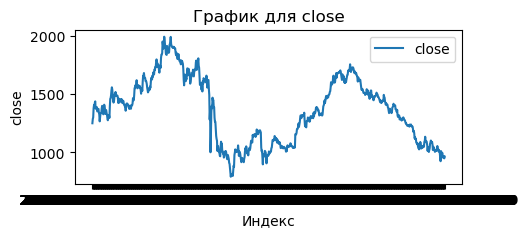


Анализ выбросов:

Выбросы не найдены.
HYDR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


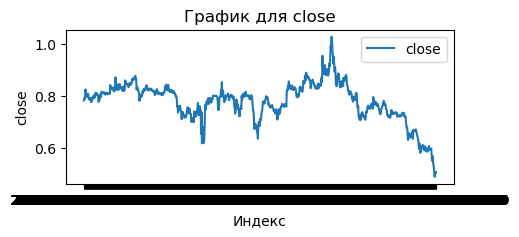


Анализ выбросов:
Найдены выбросы в колонке: close
end
2023-08-03 23:59:59    0.9548
2023-08-31 23:59:59    0.9917
2023-09-01 23:59:59    0.9879
2023-09-04 23:59:59    1.0257
2023-09-05 23:59:59    1.0278
2023-09-06 23:59:59    1.0000
2023-09-07 23:59:59    0.9617
2023-09-08 23:59:59    0.9577
2024-07-10 23:59:59    0.5970
2024-07-12 23:59:59    0.6051
2024-07-15 23:59:59    0.5822
2024-07-16 23:59:59    0.5865
2024-07-17 23:59:59    0.5881
2024-07-18 23:59:59    0.5995
2024-07-19 23:59:59    0.6007
2024-07-26 23:59:59    0.6014
2024-07-29 23:59:59    0.5913
2024-07-30 23:59:59    0.5945
2024-07-31 23:59:59    0.6064
2024-08-01 23:59:59    0.6003
2024-08-02 23:59:59    0.6008
2024-08-05 23:59:59    0.5874
2024-08-06 23:59:59    0.5903
2024-08-07 23:59:59    0.5953
2024-08-08 23:59:59    0.5868
2024-08-09 23:59:59    0.5925
2024-08-12 23:59:59    0.5948
2024-08-13 23:59:59    0.6089
2024-08-14 23:59:59    0.6010
2024-08-15 23:59:59    0.5981
2024-08-16 23:59:59    0.5939
2024-08-19 23:5

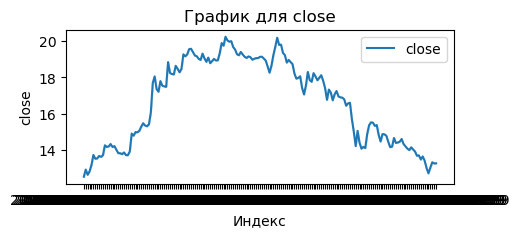


Анализ выбросов:

Выбросы не найдены.
FLOT
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


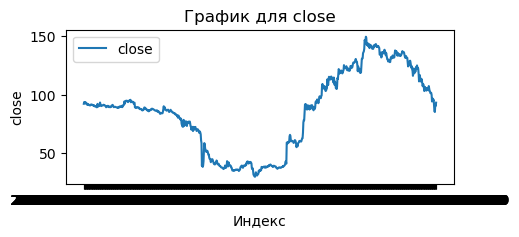


Анализ выбросов:

Выбросы не найдены.
UPRO
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


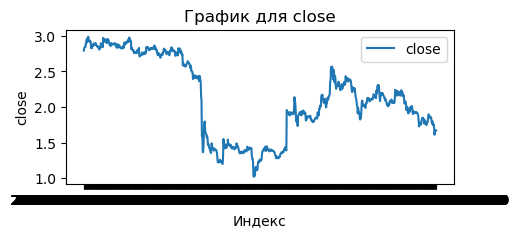


Анализ выбросов:

Выбросы не найдены.
ALRS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


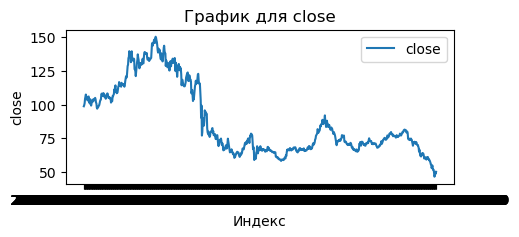


Анализ выбросов:

Выбросы не найдены.
LKOH
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


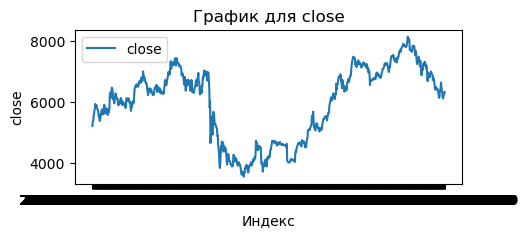


Анализ выбросов:

Выбросы не найдены.
NLMK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


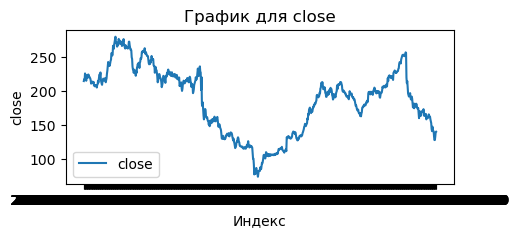


Анализ выбросов:

Выбросы не найдены.
ROSN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


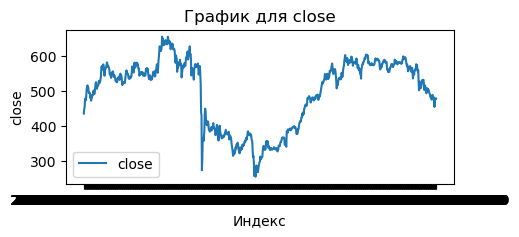


Анализ выбросов:

Выбросы не найдены.
SBER
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


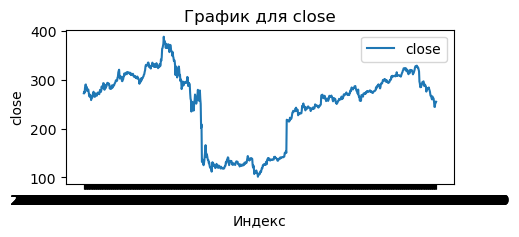


Анализ выбросов:

Выбросы не найдены.
GMKN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


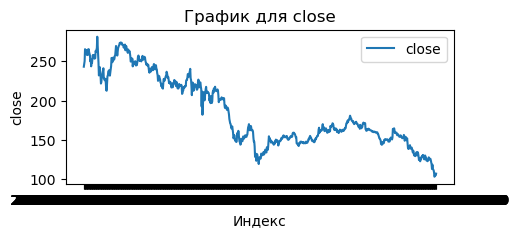


Анализ выбросов:

Выбросы не найдены.
GAZP
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


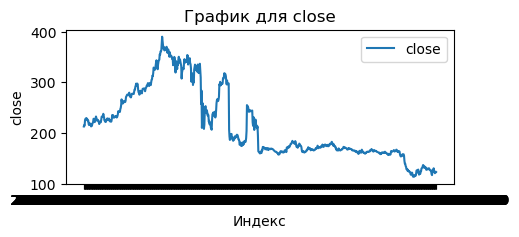


Анализ выбросов:

Выбросы не найдены.
MTSS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


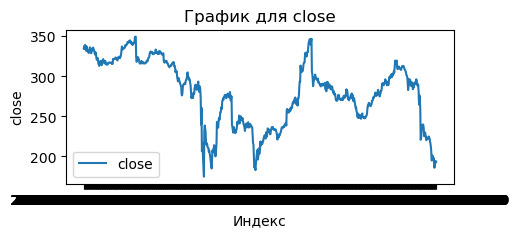


Анализ выбросов:

Выбросы не найдены.
SNGS
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


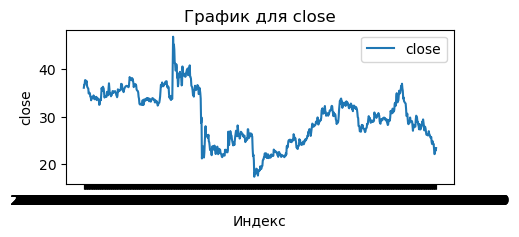


Анализ выбросов:

Выбросы не найдены.
SNGSp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


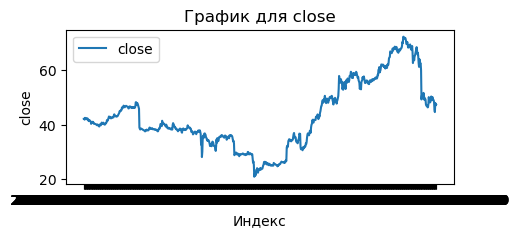


Анализ выбросов:

Выбросы не найдены.
TRNFp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


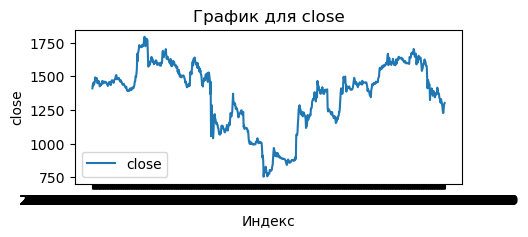


Анализ выбросов:

Выбросы не найдены.
SIBN
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


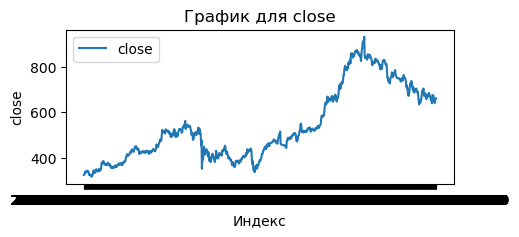


Анализ выбросов:

Выбросы не найдены.
PHOR
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


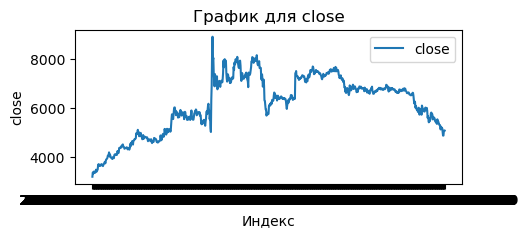


Анализ выбросов:

Выбросы не найдены.
RTKM
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


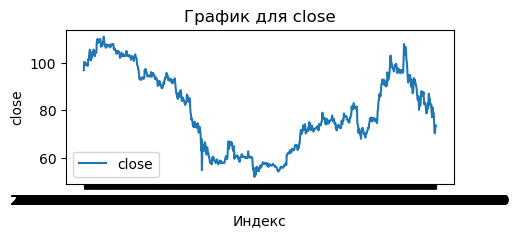


Анализ выбросов:

Выбросы не найдены.
RTKMp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


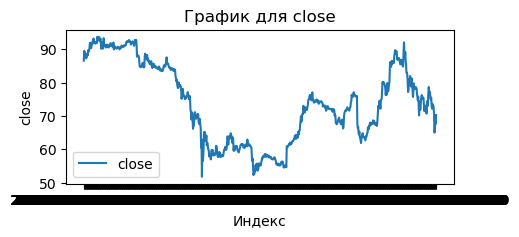


Анализ выбросов:

Выбросы не найдены.
TTLK
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


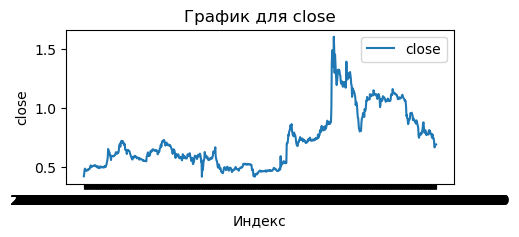


Анализ выбросов:
Найдены выбросы в колонке: close
end
2023-09-05 23:59:59    1.3760
2023-09-06 23:59:59    1.4905
2023-09-12 23:59:59    1.6060
2023-09-13 23:59:59    1.5005
2023-09-15 23:59:59    1.4560
2023-09-18 23:59:59    1.3820
2023-10-25 23:59:59    1.3950
Name: close, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
MOEX
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


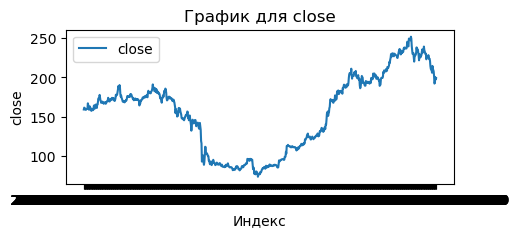


Анализ выбросов:

Выбросы не найдены.
SBERp
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


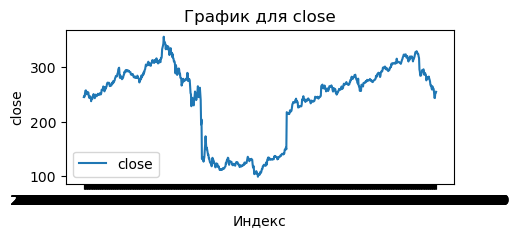


Анализ выбросов:
Найдены выбросы в колонке: close
end
2022-09-26 23:59:59    104.09
2022-09-27 23:59:59    108.51
2022-09-28 23:59:59    106.61
2022-09-29 23:59:59    105.23
2022-09-30 23:59:59    105.66
2022-10-04 23:59:59    107.09
2022-10-05 23:59:59    104.85
2022-10-06 23:59:59    105.32
2022-10-07 23:59:59     99.33
2022-10-10 23:59:59    103.20
2022-10-11 23:59:59    103.70
2022-10-12 23:59:59    102.91
2022-10-13 23:59:59    103.07
2022-10-14 23:59:59    103.73
2022-10-17 23:59:59    108.30
2022-10-18 23:59:59    106.43
2022-10-19 23:59:59    107.40
Name: close, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.
FESH
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


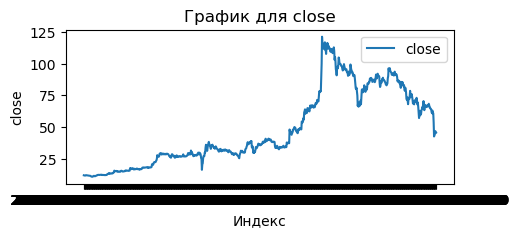


Анализ выбросов:

Выбросы не найдены.
FIVE
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


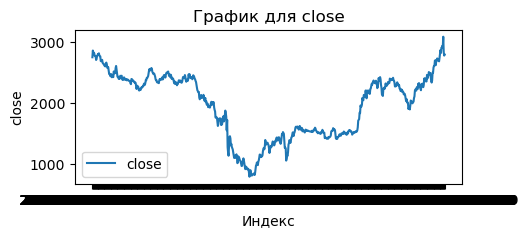


Анализ выбросов:

Выбросы не найдены.
TCSG
Проверка пропусков:
Series([], dtype: int64)

Графики текущей ситуации:


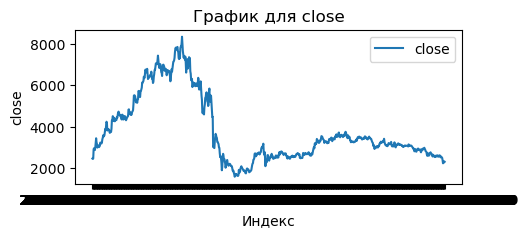


Анализ выбросов:
Найдены выбросы в колонке: close
end
2021-08-17 23:59:59    7433.8
2021-10-12 23:59:59    7331.4
2021-10-13 23:59:59    7610.4
2021-10-14 23:59:59    7767.6
2021-10-15 23:59:59    7820.2
2021-10-18 23:59:59    7724.0
2021-10-19 23:59:59    7805.0
2021-10-20 23:59:59    7824.4
2021-10-21 23:59:59    7853.0
2021-10-22 23:59:59    7660.0
2021-10-25 23:59:59    7600.0
2021-10-26 23:59:59    7310.2
2021-10-28 23:59:59    7396.8
2021-10-29 23:59:59    7310.0
2021-11-01 23:59:59    7790.8
2021-11-02 23:59:59    7867.0
2021-11-03 23:59:59    7852.8
2021-11-05 23:59:59    8025.0
2021-11-08 23:59:59    8345.0
2021-11-09 23:59:59    7983.6
2021-11-10 23:59:59    7654.2
2021-11-11 23:59:59    7508.0
2021-11-12 23:59:59    7334.0
2021-11-15 23:59:59    7422.6
2021-11-16 23:59:59    7395.6
2021-11-18 23:59:59    7382.0
2021-12-01 23:59:59    7358.0
2021-12-03 23:59:59    7307.6
Name: close, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные дан

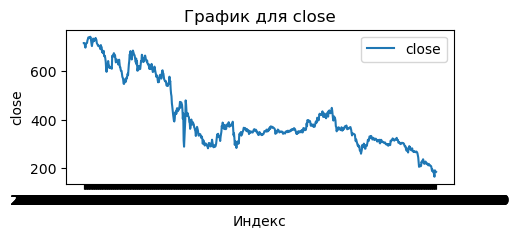


Анализ выбросов:
Найдены выбросы в колонке: close
end
2021-03-23 23:59:59    728.0
2021-03-24 23:59:59    732.5
2021-03-25 23:59:59    739.9
2021-03-26 23:59:59    738.7
2021-03-29 23:59:59    739.0
2021-03-30 23:59:59    741.4
2021-03-31 23:59:59    737.0
2021-04-01 23:59:59    743.0
2021-04-02 23:59:59    738.9
2021-04-05 23:59:59    724.3
2021-04-12 23:59:59    735.3
2021-04-13 23:59:59    731.1
2021-04-14 23:59:59    725.0
2021-04-15 23:59:59    730.9
2021-04-16 23:59:59    727.9
2021-04-19 23:59:59    732.6
2021-04-20 23:59:59    738.0
2021-04-21 23:59:59    733.0
2021-04-22 23:59:59    730.0
Name: close, dtype: float64

Выбросы были найдены. Оцените, действительно ли это выбросы или реальные данные.


In [148]:
for column in ['close']:
    print(column)
    df_kotirovki_analyze_data = df_kotirovki[[column, 'symbol', 'end']].set_index('end')
    for symbol in symbol_list:
        print(symbol)
        analyze_data(df_kotirovki_analyze_data.loc[df_kotirovki_analyze_data['symbol'] == symbol])